                                                                                    Marta Granero i Martí
# Cuarta lista - Problema individual 3

## Perder hasta la camisa

### Las finanzas son un area de aplicación del aprendizaje automático y las redes neuronales. Esta no es sencilla dados los múltiples factores que intervienen y lo difícil que es representarlos y estimarlos adecuadamente. A veces lo que nos puede parecer una aplicación obvia y directa de métodos a los datos no lo es tanto y eso nos puede hacer perder hasta la camisa.

### En este problema trabajaremos con datos reales del NASDAQ sobre la cotización de las acciones de cinco empresas tecnológicas(Google, Microsoft, Apple, Intel, AMD) durante cinco años. Podéis obtener los datos mediante la función $\texttt{load\_NASDAQ}$ de la librería $\texttt{apafib}$. Esta os retorará un dataframe que tiene tres columnas para cada acción, el valor final de la acción al final del dia (P), el volumen de acciones que se intercambiaron (V) y la diferencia entre el mayor y el menor precio al que cotizaron en el día (GAP). Resuelve los siguientes apartados ilustrando los resultados de la manera que te parezca más adecuada.


In [1]:
import apafib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm

from pandas.testing import assert_frame_equal #l'error del testing

from scipy import stats
from scipy.stats import normaltest, anderson

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import  ConfusionMatrixDisplay,classification_report,\
                             RocCurveDisplay, PrecisionRecallDisplay,\
                             accuracy_score, f1_score, precision_score, recall_score

from sklearn.model_selection import cross_val_score
from sklearn import set_config

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Binarizer
from sklearn.decomposition import PCA

from statsmodels.genmod.generalized_linear_model import GLM

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB

from sklearn.neural_network import MLPClassifier, MLPRegressor

from sklearn.model_selection import GridSearchCV,train_test_split, cross_val_score, TimeSeriesSplit

from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from numpy.random import choice

from IPython.display import display, HTML #core.display deprecated
show_html = lambda html: display(HTML(html))

from yellowbrick.target.feature_correlation import feature_correlation
from yellowbrick.classifier import precision_recall_curve
from yellowbrick.classifier.rocauc import roc_auc

from numpy.lib.stride_tricks import sliding_window_view
from sklearn.metrics import make_scorer

from sklearn.svm import LinearSVC, SVC
from sklearn.svm import LinearSVR, SVR

from skopt import BayesSearchCV

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

pd.options.mode.chained_assignment = None  # default='warn'import pandas as pd
pd.set_option('display.precision', 5)

/Users/mac/Library/Python/3.10/lib/python/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Exploración previa de los datos

En este cuarto problema de la lista nuesto objetivo será intentar analizar como los datos reales del NASDAQ sobre la cotización de las acciones de cinco empresas tecnológicas *(Google, Microsoft, Apple, Intel, AMD)* durante tres/cuatro años, influyen en el valor de las acciones de *Google* para poder saber si el valor de estas subió o bajó respecto al día anterior. Por lo tanto, no intentamos predecir el valor de las acciones mediante las ventanas pasadas, sino que únicamente saber si estas subieron o bajaron, i.e resolveremos un problema de clasificación.

#### Cargamos el conjunto de datos desde la librería $\texttt{apafib}$

In [2]:
from apafib import load_NASDAQ

nasdaq_data = load_NASDAQ()
nasdaq_data.head()

GOOGLE-P  GOOGLE-V  GOOGLE-GAP  MSFT-P    MSFT-V  MSFT-GAP   AAPL-P  \
0   45.3330  18846560      0.4800   72.15  17698800      0.78  39.3025   
1   46.2345  23326400      0.7192   73.16  14333220      0.89  39.9450   
2   46.3500  21771500      0.5285   72.72  13758650      0.62  39.9950   
3   46.0640  25323820      0.7670   72.69  17097240      0.79  39.8175   
4   45.7945  21055280      0.5027   72.82  12790300      0.87  39.9650   

      AAPL-V  AAPL-GAP  INTEL-P   INTEL-V  INTEL-GAP  AMD-P     AMD-V  AMD-GAP  
0  105320280    0.6950    34.92  26479700       0.58  12.05  58786300    0.560  
1   86259560    0.4950    34.65  26093400       0.57  12.17  38946780    0.230  
2   77507760    0.3975    34.66  19775620       0.43  12.48  44193270    0.585  
3   79128680    0.5475    34.71  14283180       0.34  12.50  37161680    0.320  
4  100738400    0.3225    34.67  14714810       0.35  12.43  29650370    0.320

#### Breve información de las features del dataset

In [3]:
nasdaq_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   GOOGLE-P    1259 non-null   float64
 1   GOOGLE-V    1259 non-null   int64  
 2   GOOGLE-GAP  1259 non-null   float64
 3   MSFT-P      1259 non-null   float64
 4   MSFT-V      1259 non-null   int64  
 5   MSFT-GAP    1259 non-null   float64
 6   AAPL-P      1259 non-null   float64
 7   AAPL-V      1259 non-null   int64  
 8   AAPL-GAP    1259 non-null   float64
 9   INTEL-P     1259 non-null   float64
 10  INTEL-V     1259 non-null   int64  
 11  INTEL-GAP   1259 non-null   float64
 12  AMD-P       1259 non-null   float64
 13  AMD-V       1259 non-null   int64  
 14  AMD-GAP     1259 non-null   float64
dtypes: float64(10), int64(5)
memory usage: 147.7 KB


#### Breve estadística descriptiva sobre el conjunto de datos

In [4]:
nasdaq_data.describe(include='all')

GOOGLE-P     GOOGLE-V  GOOGLE-GAP      MSFT-P       MSFT-V  \
count  1259.00000  1.25900e+03  1259.00000  1259.00000  1.25900e+03   
mean     82.35332  3.09171e+07     1.74018   181.82056  2.95393e+07   
std      32.32053  1.34779e+07     1.20997    78.62105  1.29942e+07   
min      45.33300  6.93506e+06     0.23800    72.15000  7.42560e+06   
25%      56.10350  2.25695e+07     0.87130   108.15000  2.12515e+07   
50%      67.36500  2.77301e+07     1.37100   163.49000  2.62929e+07   
75%     112.94150  3.53114e+07     2.21875   252.48500  3.37407e+07   
max     150.70900  1.23894e+08     9.21550   343.11000  1.10945e+08   

         MSFT-GAP      AAPL-P       AAPL-V    AAPL-GAP     INTEL-P  \
count  1259.00000  1259.00000  1.25900e+03  1259.00000  1259.00000   
mean      3.81282    90.35068  1.18475e+08     2.06824    50.89460   
std       2.91281    46.26909  5.50402e+07     1.69404     6.68404   
min       0.34000    35.54750  4.10000e+07     0.21350    34.52000   
25%       1.66000    47.48250  8.19392e+07     0.77625    46.72000   
50%       3.06000    71.93250  1.04270e+08     1.50250    50.59000   
75%       5.14125   133.64000  1.38281e+08     2.92500    55.38000   
max      23.64000   182.01000  4.26885e+08    12.81000    68.47000   

           INTEL-V   INTEL-GAP       AMD-P        AMD-V     AMD-GAP  
count  1.25900e+03  1259.00000  1259.00000  1.25900e+03  1259.00000  
mean   2.90096e+07     1.21675    56.72203  6.91563e+07     2.40923  
std    1.46416e+07     0.73939    38.70411  3.59560e+07     2.17798  
min    6.31318e+06     0.21000     9.53000  1.10358e+07     0.12000  
25%    1.97808e+07     0.76000    21.66500  4.33160e+07     0.82000  
50%    2.58458e+07     1.02650    48.21000  5.85973e+07     1.72000  
75%    3.40032e+07     1.45000    87.09500  8.56140e+07     3.29500  
max    1.82270e+08     8.62000   161.91000  3.23844e+08    15.90000

Podemos hacer una breve exploración de los datos y nos podemos fijar que tenemos **15 variables predictivas y 1259 muestras**, días que nos van a intentar ayudar a resolver este problema de clasificación.

Nuestra variable objetivo no aparece aquí, pues esta la crearemos más adelante.

A continuación visualizaremos este conjunto de datos, todos numéricos usando histogramas para mostrar la distribución de estas variables numéricas. Esta visualización nos va a permitir extraer información sobre la possible gaussianidad de ciertas variables. Hacer una visualización de los datos es esencial, pues nos dará una visión preliminar de las características de las que disponen nuestros datos. Lo vemos a continuación:

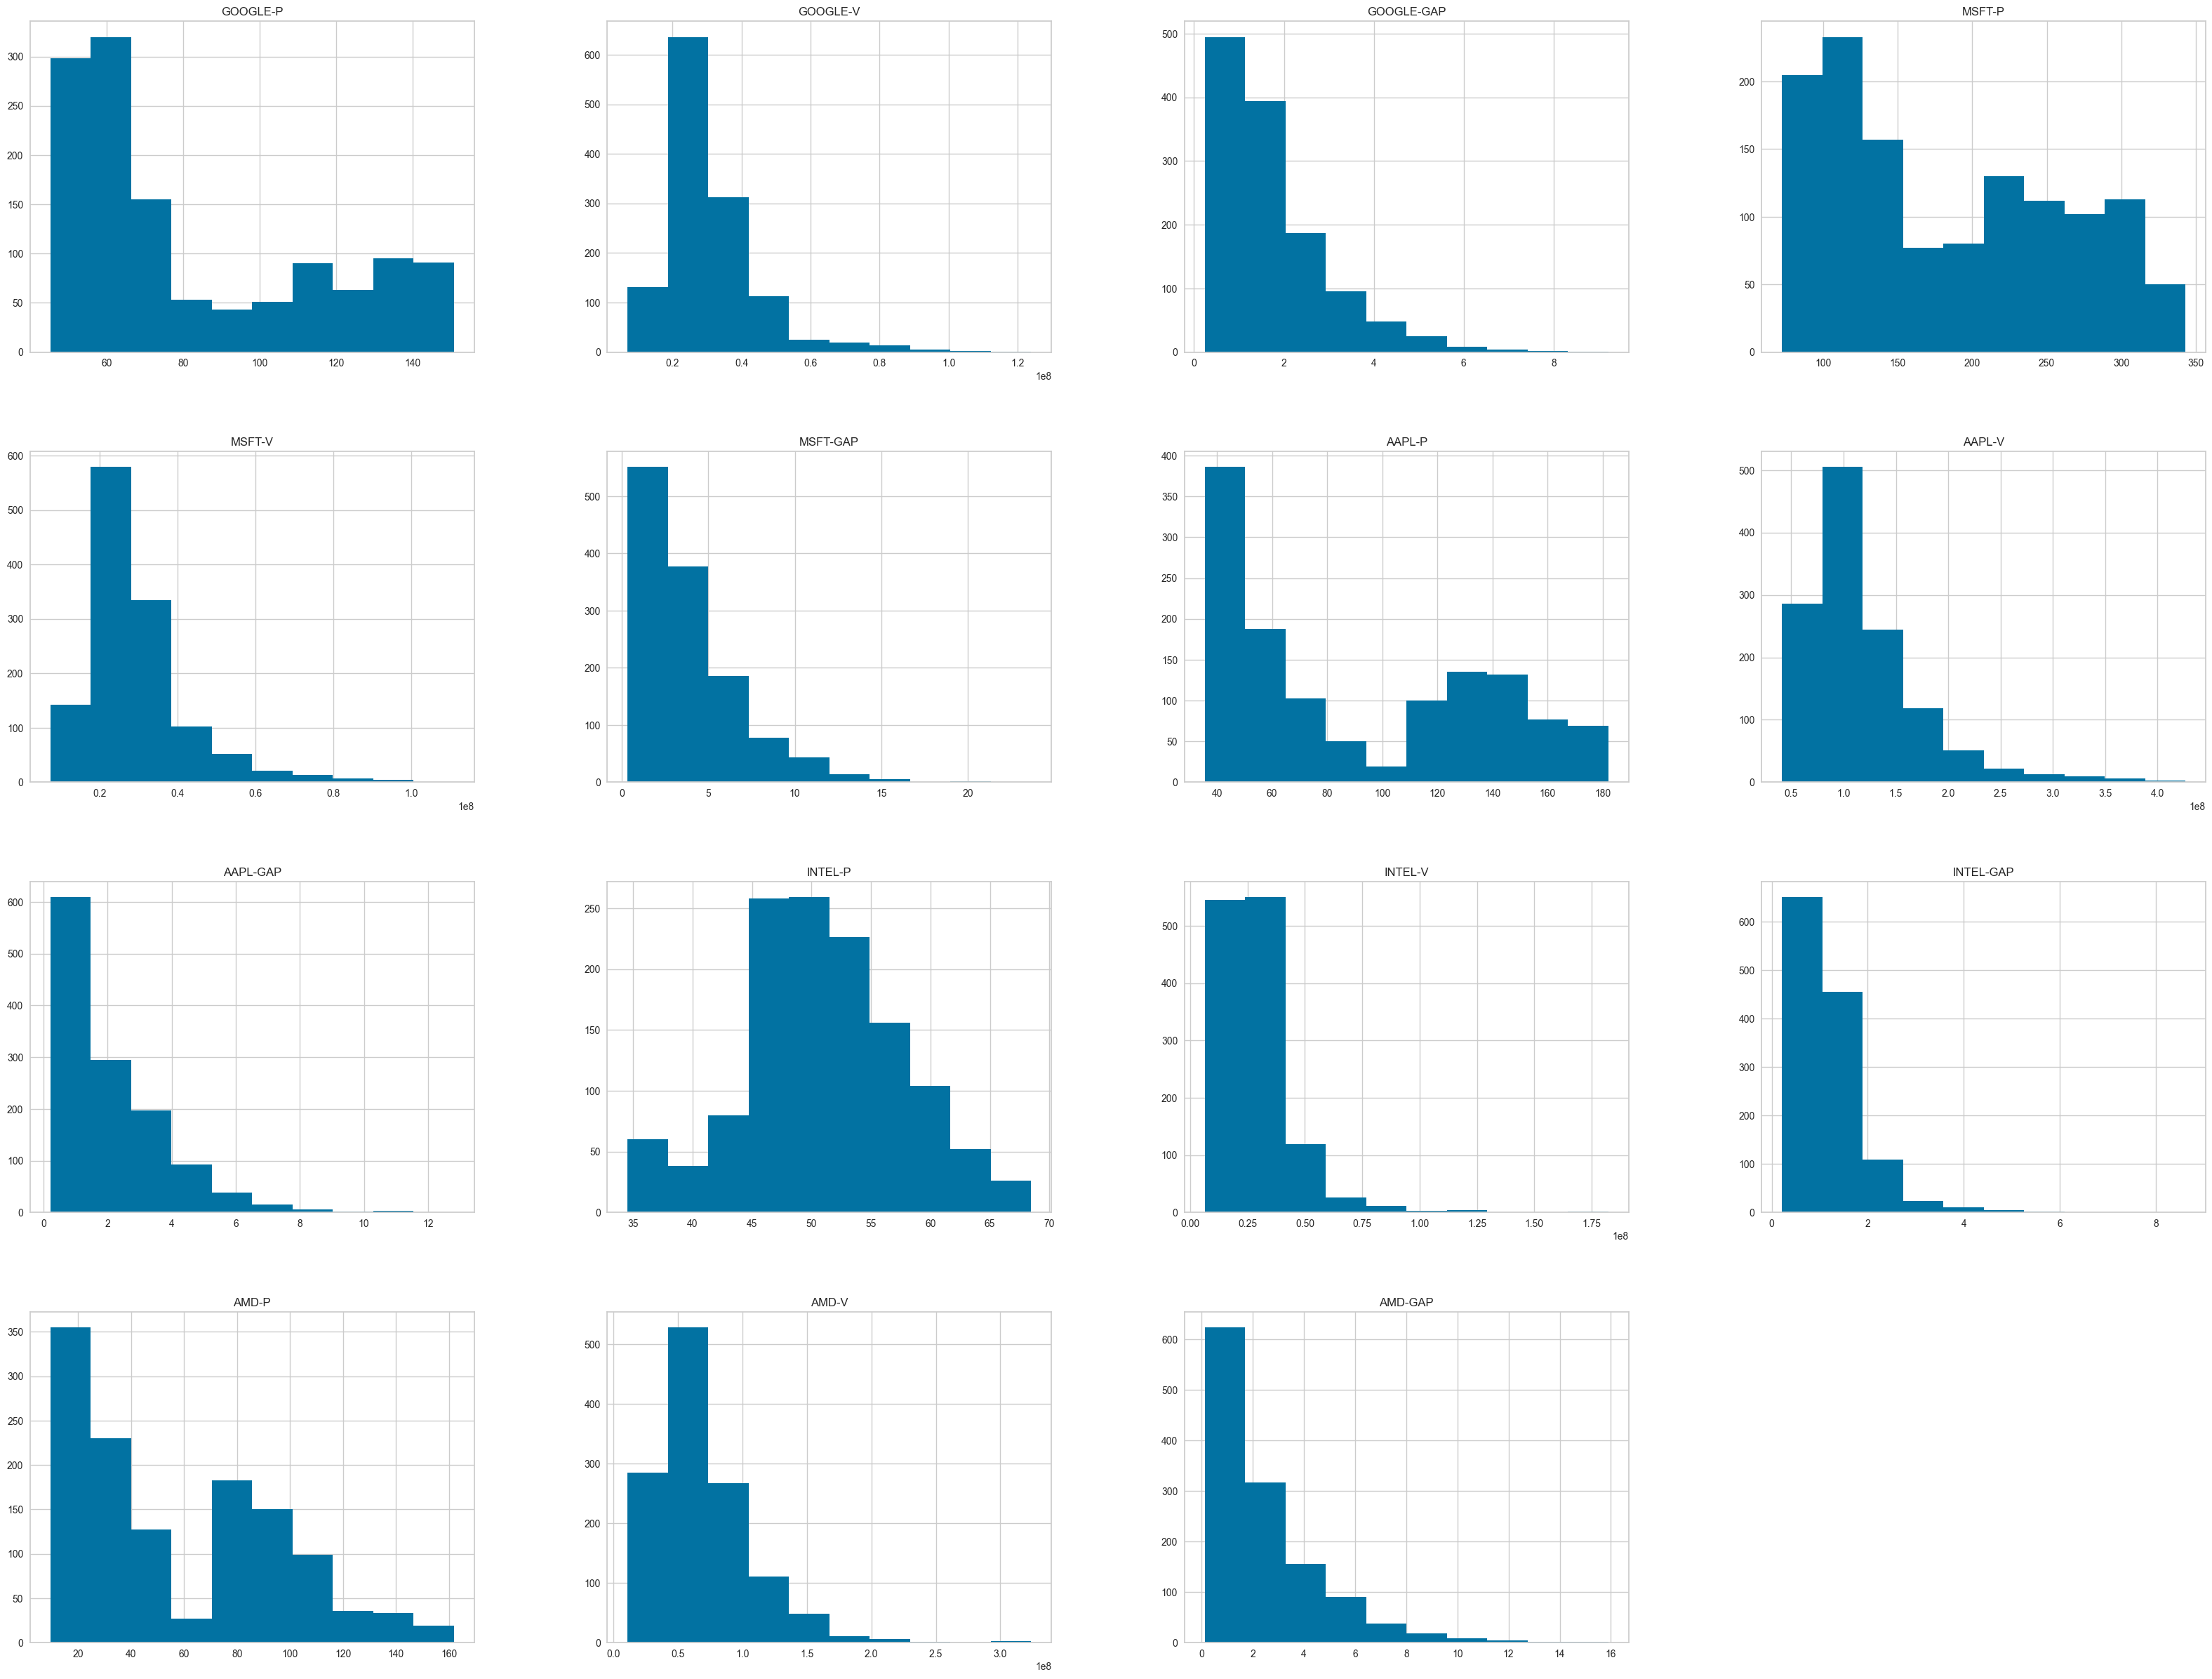

In [5]:
nasdaq_data.hist(figsize=(40,30));

#### Comprobaremos si algunas de nuestras variables numéricas siguen una distribución Normal

Podemos ver el valor del estadístico y del p-valor para las distintas variables.

In [6]:
nasdaq_data.columns

for column in nasdaq_data.columns:
    print("Columna", column, "test normal:", normaltest(nasdaq_data[column], nan_policy='omit'))
    if (column == "AAPL-P" or column == "INTEL-P"):
        print("Columna", column, "test normal:", anderson(nasdaq_data[column], dist="norm")) 

Columna GOOGLE-P test normal: NormaltestResult(statistic=290.2413979892535, pvalue=9.43802702752558e-64)
Columna GOOGLE-V test normal: NormaltestResult(statistic=576.531352747134, pvalue=6.424028053915288e-126)
Columna GOOGLE-GAP test normal: NormaltestResult(statistic=424.50548674230595, pvalue=6.603965337249481e-93)
Columna MSFT-P test normal: NormaltestResult(statistic=1219.3396844181193, pvalue=1.6739857079431616e-265)
Columna MSFT-V test normal: NormaltestResult(statistic=524.810281972022, pvalue=1.0936925321884651e-114)
Columna MSFT-GAP test normal: NormaltestResult(statistic=463.5729325091469, pvalue=2.1697851161321357e-101)
Columna AAPL-P test normal: NormaltestResult(statistic=17161.884624920884, pvalue=0.0)
Columna AAPL-P test normal: AndersonResult(statistic=69.12084902054039, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Columna AAPL-V test normal: NormaltestResult(statistic=526.289600754944, pvalue=5.2

Como podemos apreciar tenemos una feature que sigue una distribución normal. Esta es la variable:

* **INTEL-P**, con un p-value de 0.989

#### Asimismo podemos ver la posible normalidad de las variables usando los boxplots.

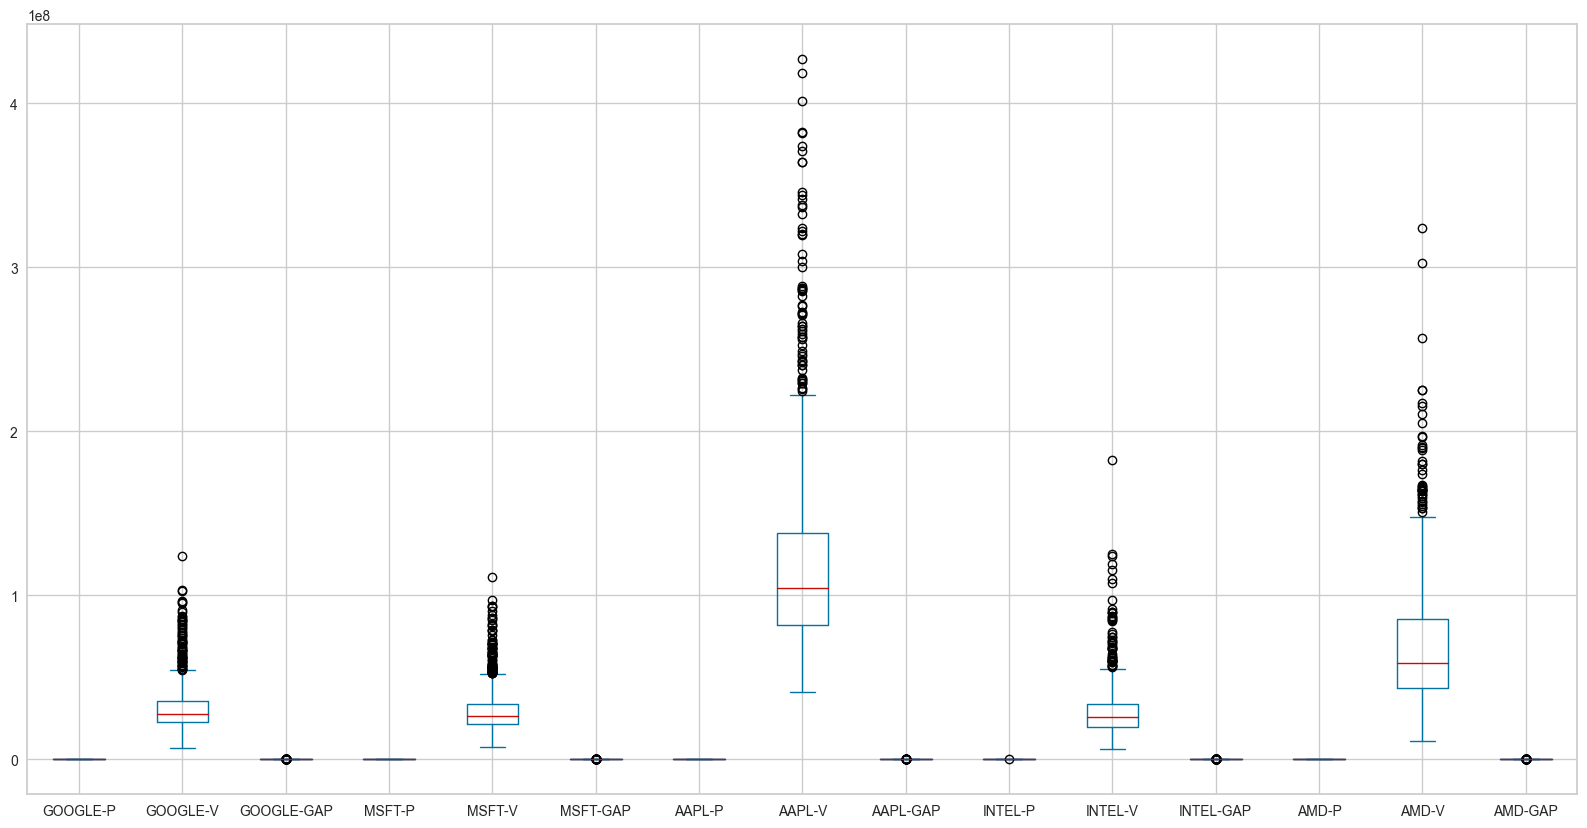

In [7]:
nasdaq_data.plot.box(figsize=(20,10));

#### Correlación entre distintas variables predictivas

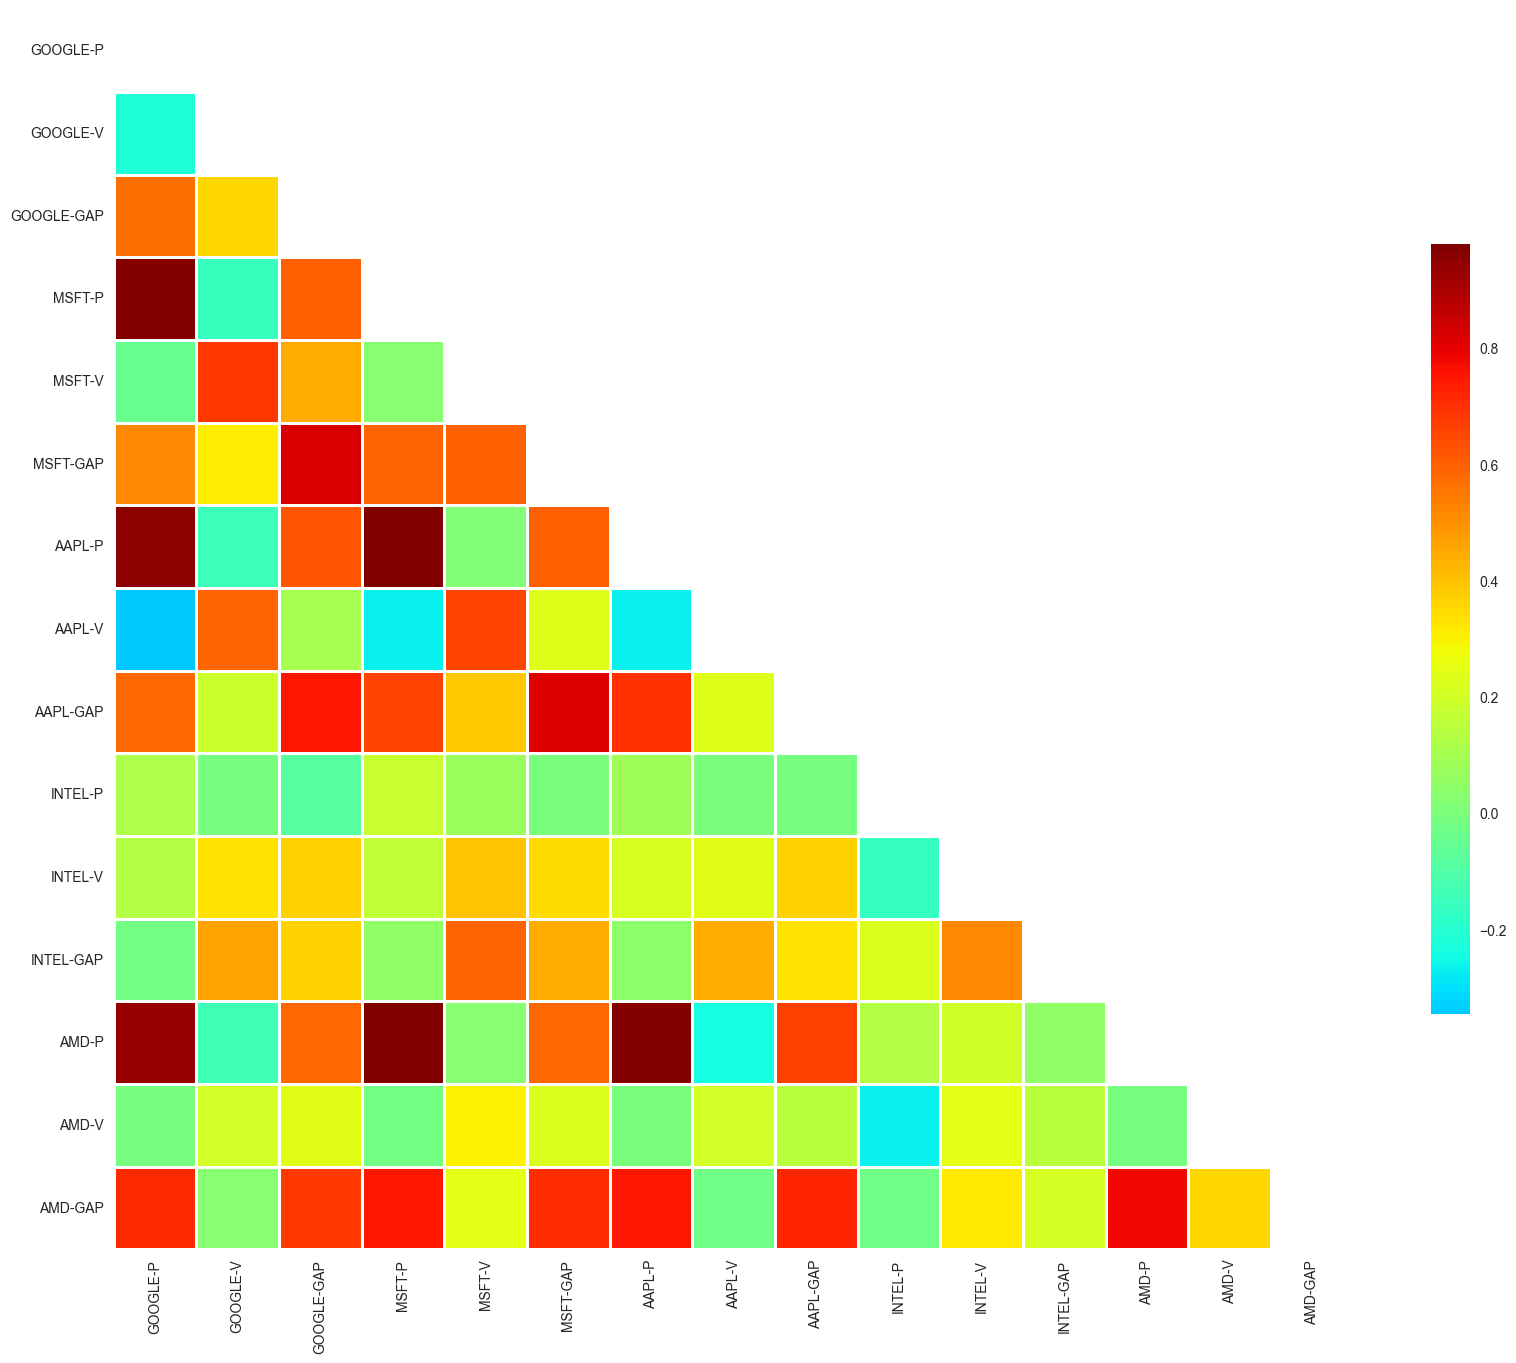

In [8]:
corr = nasdaq_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(20, 20))
sns.heatmap(corr, mask=mask, cmap='jet',  center=0, square=True, linewidths=.8, cbar_kws={"shrink": .5});

<a name="posible-predecir"></a>
Como podemos apreciar, existen múltiples relaciones entre las distintas variables predictoras. Este heatmap nos podría dar algunas pistas sobre como algunas variables pueden estar correlacionadas con otras. Si nos fíjamos, las variables del precio de cierre diario de las distintas teconógicas paracen estar muy correlacionados, si nos fijamos entre:

* GOOGLE-P - {AMD-P, AAPL-P, MSFT-P}
* MSFT-P - {AMD-P, AAPL-P}
* AAPL-P - {AMD-P}

Notemos que el precio de cierre de la tecnológica INTEL es la que parece estar menos correlacionada con las otras tecnológicas.

Además el GAP de cada una de las tecnoógicas también es una variable que nos puede ser de ayuda, esta pues es la diferencia entre el máximo i el mínimo precio al que se cotizaron las acciones al final del dia, esta pues también puede ser de esperar que dependa del volumen de negociaciones de las acciones de cada tecnológica.

Parece pero que para Apple, el volumen no influye demasiado en el GAP al final del dia. Ya que parece que sin embargo, el gap no está directamente relacionado con el volumen de la acción en el Nasdaq, aunque un mayor volumen de negociación puede ser uno de los factores que contribuyan a un mayor gap en el precio de la acción.

Estamos tratando con un problema complejo y auqnue parezca que tenemos una clara correlación, no deja de ser el mercado de valores. Por ejemplo el caso del GAP de AMD.

El gap de un valor, como AMD, puede verse influido por diversos factores, como las noticias, los cambios en la confianza del mercado y el volumen de negociación. Estos factores también pueden afectar a los gaps de otros valores que cotizan en el NASDAQ o en otras bolsas. En consecuencia, es posible que el gap de un valor, como AMD, se vea influido por el gap de otras tecnológicas como estamos viendo. 

Sin embargo, la relación entre los gaps de diferentes valores es compleja y puede variar mucho en función de las circunstancias específicas. Es importante señalar que el GAP de una acción no está causada directamente por el GAP de otra acción, sino más bien por los diversos factores que pueden afectar a la demanda y la oferta de la acción. Más adelante podemos ver a lo largo de casi 4 años cuál ha sido la evolución del mercado para las 5 tecnológicas y sus valores.

Podríamos intentar sacar algunas conclusiones, pero el mercado bursátil es un sistema complejo y dinámico, y los precios de los distintos valores que cotizan en el Nasdaq o en otras bolsas pueden verse influidos por una amplia gama de factores. 

Estos factores pueden incluir el rendimiento de las própias empresas individuales, las condiciones del mercado y las notícias, entre otros factores. Aunque los resultados de una empresa pueden influir en el mercado bursátil en su conjunto, los precios de las acciones individuales suelen estar más estrechamente vinculados a los resultados de las propias empresas que a los de otras empresas. 

Aún así, es importante tener en cuenta que el mercado bursátil está interconectado y que los precios de las distintas acciones pueden verse afectados por muchos factores diferentes, tanto internos como externos a las empresas individuales, como se refleja en el heatmap.

### Visualización del precio de cierre diario de las acciones de las distintas tecnológicas al largo de los 5 años

### GOOGLE-P

In [9]:
nasdaq_data['GOOGLE-P'].loc[:].iplot(fill=True,colors=['blue'])

Vemos que la tendencia del precio de cierre de Google en los últimos años ha tenido una tendencia alcista. 

### MSFT-P

In [10]:
nasdaq_data['MSFT-P'].loc[:].iplot(fill=True,colors=['green'])

Al igual que Google el precio de cierre de las acciones también ha ido al alza.

### AAPL-P

In [11]:
nasdaq_data['AAPL-P'].loc[:].iplot(fill=True,colors=['red'])

También lo ha hecho APPLE.

### INTEL-P

In [12]:
nasdaq_data['INTEL-P'].loc[:].iplot(fill=True,colors=['orange'])

Sin embargo el precio de de cierre de las acciones de INTEL se ha mantenido

### AMD-P

In [13]:
nasdaq_data['AMD-P'].loc[:].iplot(fill=True,colors=['rose'])

### Visualización del volumen de cierre diario de las acciones de las distintas tecnológicas al largo de los 5 años

Como se puede apreciar en el volumen de cierre de todas las tecnológicas, vemos que durante un periodo de tiempo grande, de aproximadamente casi 3 meses el volumen de negociaciones fue prolongado(a partir del día 600) y según para qué tecnológica se intercambiaron un número alto de acciones.

Esto se debe a que seguramente fue un día importante para el mercado de valores. Este descenso del precio, y el incremento del volumen, parece que encajaria con el movimiento del mercado que provoco el SARS-CoV-2 en el mercado norteamericano. 

Por lo tanto estariamos tratando con datos recientes de los últimos 3-4 años aproximadamente.

### GOOGLE-V

In [14]:
nasdaq_data['GOOGLE-V'].loc[:].iplot(fill=False,colors=['blue'])

### MSFT-V

In [15]:
nasdaq_data['MSFT-V'].loc[:].iplot(fill=False,colors=['green'])

### AAPL-V

In [16]:
nasdaq_data['AAPL-V'].loc[:].iplot(fill=False,colors=['red'])

### INTEL-V

In [17]:
nasdaq_data['INTEL-V'].loc[:].iplot(fill=False,colors=['orange'])

### AMD-V

In [18]:
nasdaq_data['AMD-V'].loc[:].iplot(fill=False,colors=['rose'])

### Visualización del GAP de cierre diario de las acciones de las distintas tecnológicas al largo de los 5 años

### GOOGLE-GAP

In [19]:
nasdaq_data['GOOGLE-GAP'].loc[:].iplot(fill=False,colors=['blue'])

### MSFT-GAP

In [20]:
nasdaq_data['MSFT-GAP'].loc[:].iplot(fill=False,colors=['blue'])

### AAPL-GAP

In [21]:
nasdaq_data['AAPL-GAP'].loc[:].iplot(fill=False,colors=['blue'])

### INTEL-GAP

In [22]:
nasdaq_data['INTEL-GAP'].loc[:].iplot(fill=False,colors=['blue'])

### AMD-GAP

In [23]:
nasdaq_data['AMD-GAP'].loc[:].iplot(fill=False,colors=['blue'])

### Visualización comparativa de los precios de las acciones tecnológicas

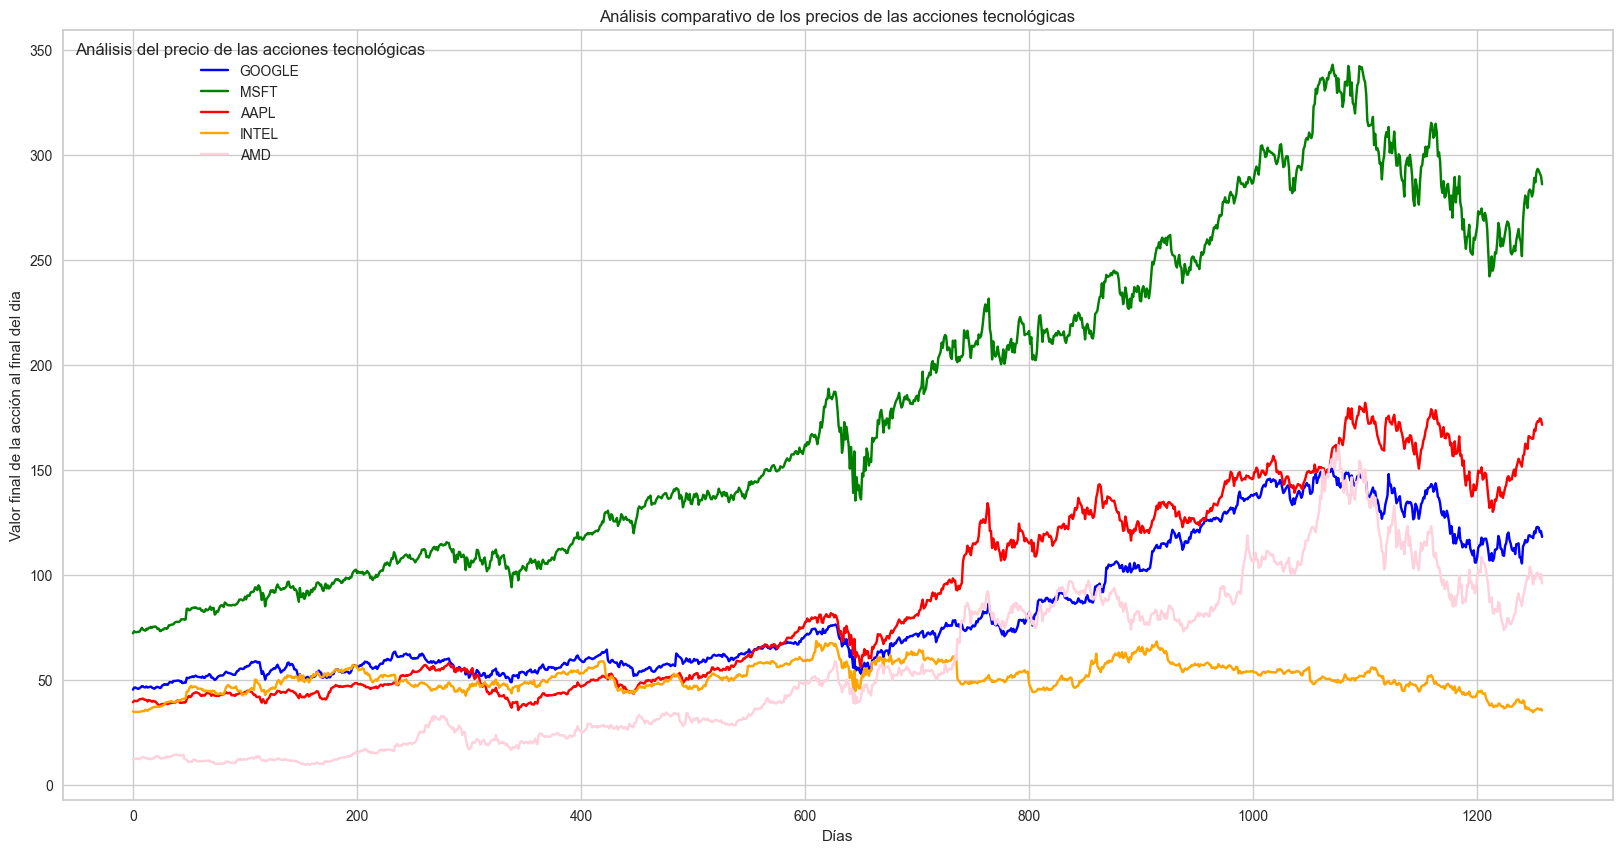

In [24]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(nasdaq_data['GOOGLE-P'],label='GOOGLE', color='blue')
ax.plot(nasdaq_data['MSFT-P'],label='MSFT', color='green')
ax.plot(nasdaq_data['AAPL-P'],label='AAPL', color='red')
ax.plot(nasdaq_data['INTEL-P'],label='INTEL', color='orange')
ax.plot(nasdaq_data['AMD-P'],label='AMD', color='#ffd1dc')
ax.set_title("Análisis comparativo de los precios de las acciones tecnológicas")
ax.set_xlabel("Días")
ax.set_ylabel("Valor final de la acción al final del dia")
ax.legend(fontsize="small", title="Análisis del precio de las acciones tecnológicas", title_fontsize=12)
plt.show()

### Visualización comparativa del volumen de acciones  tecnológicas que se intercambiaron

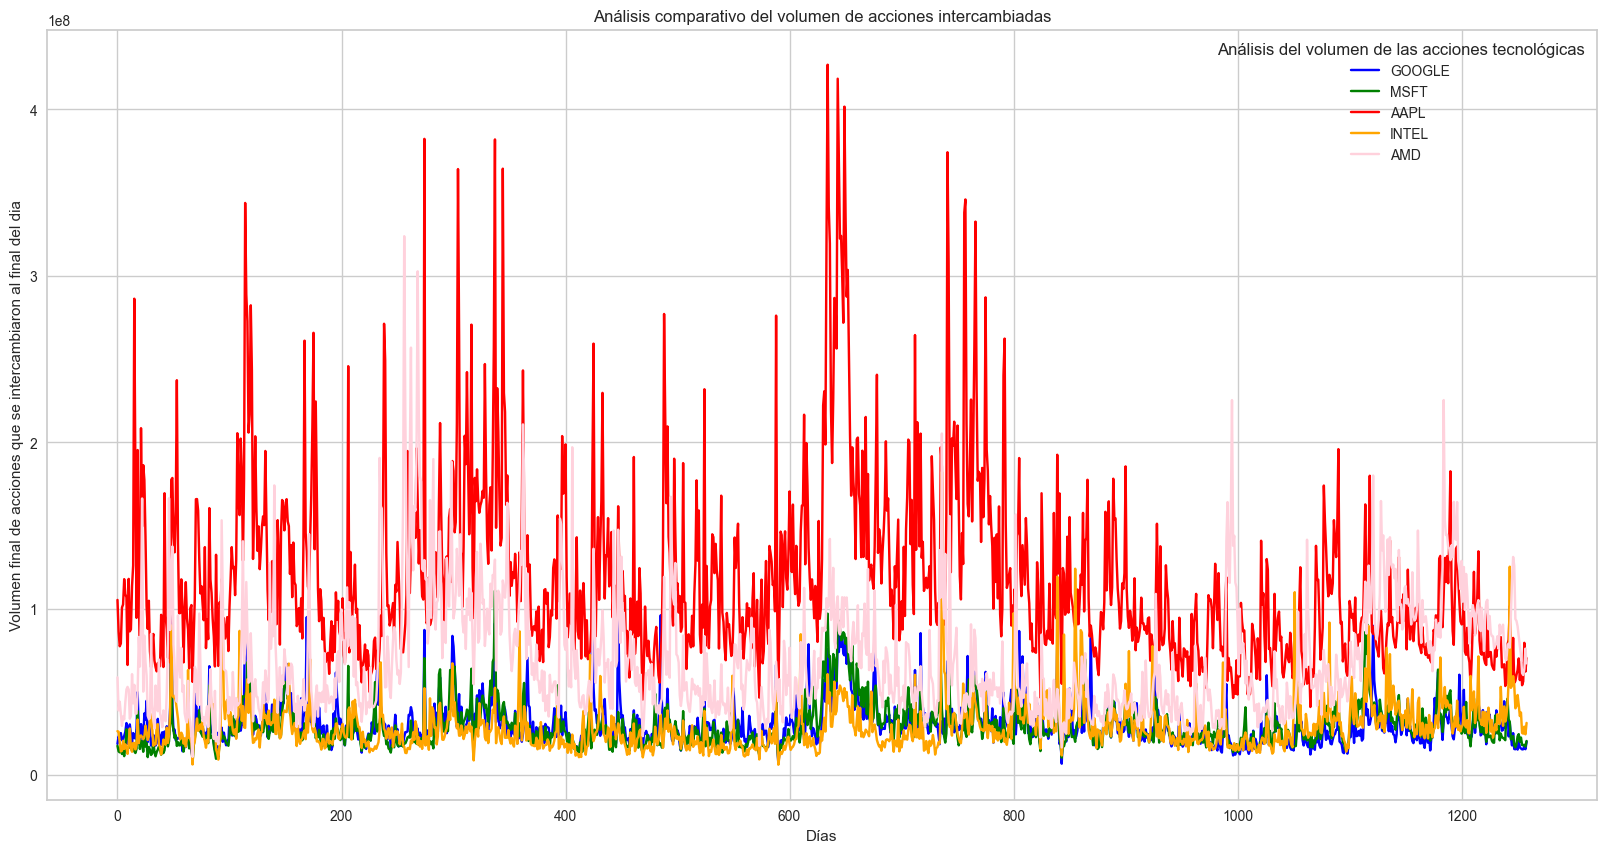

In [25]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(nasdaq_data['GOOGLE-V'],label='GOOGLE', color='blue')
ax.plot(nasdaq_data['MSFT-V'],label='MSFT', color='green')
ax.plot(nasdaq_data['AAPL-V'],label='AAPL', color='red')
ax.plot(nasdaq_data['INTEL-V'],label='INTEL', color='orange')
ax.plot(nasdaq_data['AMD-V'],label='AMD', color='#ffd1dc')
ax.set_title("Análisis comparativo del volumen de acciones intercambiadas")
ax.set_xlabel("Días")
ax.set_ylabel("Volumen final de acciones que se intercambiaron al final del dia")
ax.legend(fontsize="small", title="Análisis del volumen de las acciones tecnológicas", title_fontsize=12)
plt.show()

### Visualización comparativa del GAP de las acciones tecnológicas

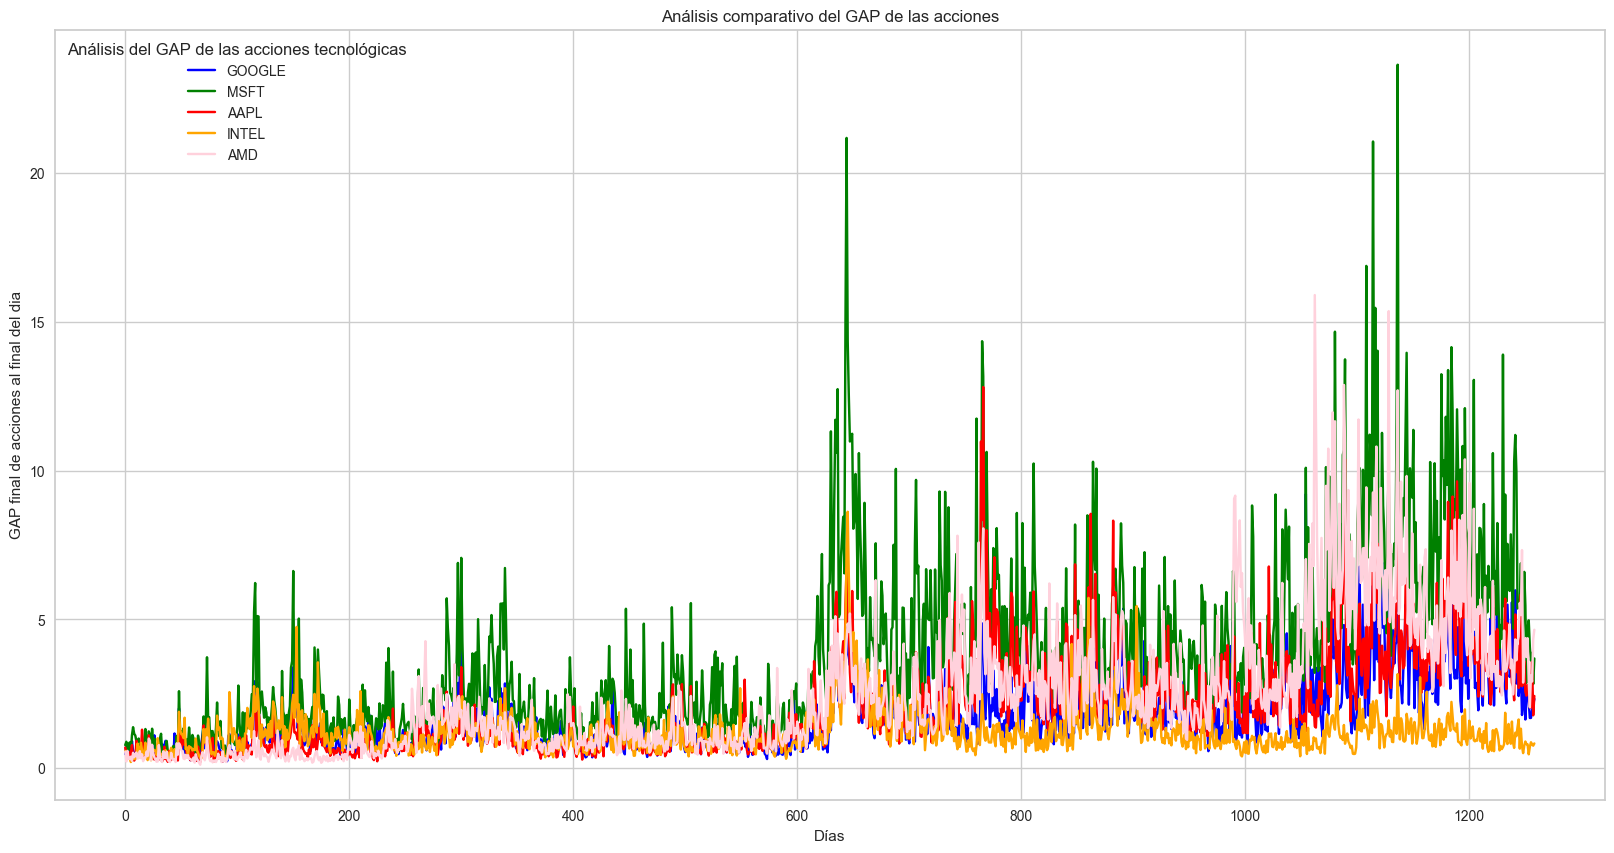

In [26]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(nasdaq_data['GOOGLE-GAP'],label='GOOGLE', color='blue')
ax.plot(nasdaq_data['MSFT-GAP'],label='MSFT', color='green')
ax.plot(nasdaq_data['AAPL-GAP'],label='AAPL', color='red')
ax.plot(nasdaq_data['INTEL-GAP'],label='INTEL', color='orange')
ax.plot(nasdaq_data['AMD-GAP'],label='AMD', color='#ffd1dc')
ax.set_title("Análisis comparativo del GAP de las acciones")
ax.set_xlabel("Días")
ax.set_ylabel("GAP final de acciones al final del dia")
ax.legend(fontsize="small", title="Análisis del GAP de las acciones tecnológicas", title_fontsize=12)
plt.show()

### Procedamos a la resolución de los apartados

#### a) Haz un estudio de las características de los datos calculando sus estadísticas, la correlación entre los datos y representándolos de la manera que te parezca interesante. ¿Crees que puede ser posible predecir unas variables a partir de otras?
#### Divide los datos en conjunto de entrenamiento (los 1000 primeros días) y test (el resto) y normalízalos a la escala [0-1]. Para generar los datos, tendrás que obtener ventanas de una cierta longitud w. La función de numpy $\texttt{sliding_window_view}$ permite obtener una vista de una matriz que corresponde a lo que necesitas. Si obtienes una ventana de longitud w+1 esa última columna contendrá el valor a predecir con los w elementos de la ventana. Tendrás que generar conjuntos de datos usando todas las variables para una longitud de ventana de 3. Fíjate en que trabajas con matrices con 3 dimensiones, adapta los datos para poder aplicar un MLP que trabaja con matrices de 2 dimensiones (usa la función reshape). Vamos a intentar resolver un problema más sencillo que predecir la cotización de las acciones con las ventanas pasadas. A partir de la variable del precio de las acciones de Google genera una variable que indique si el valor subió o bajó respecto al día anterior. Esa es la variable que intentaremos predecir, resolveremos un problema de clasificación.

Antes de llegar a este apartado ya hemos realizado un breve estudio estadístico mostrando algunas representaciones y la correlaciones de las variables predictoras. Aún así, en este apartado lo seguiremos haciendo.

#### Dividimos el conjunto de datos en entrenamiento(1000 primeros días) y test (259 días siguientes)

In [27]:
X_train = nasdaq_data.iloc[:1000]
X_test  = nasdaq_data.iloc[1000:]

X_train, X_test

X_train.shape, X_test.shape

((1000, 15), (259, 15))

#### A continuación visualizaremos el conjunto de datos de entrenamiento usando histogramas para mostrar la distribución de estas variables numéricas

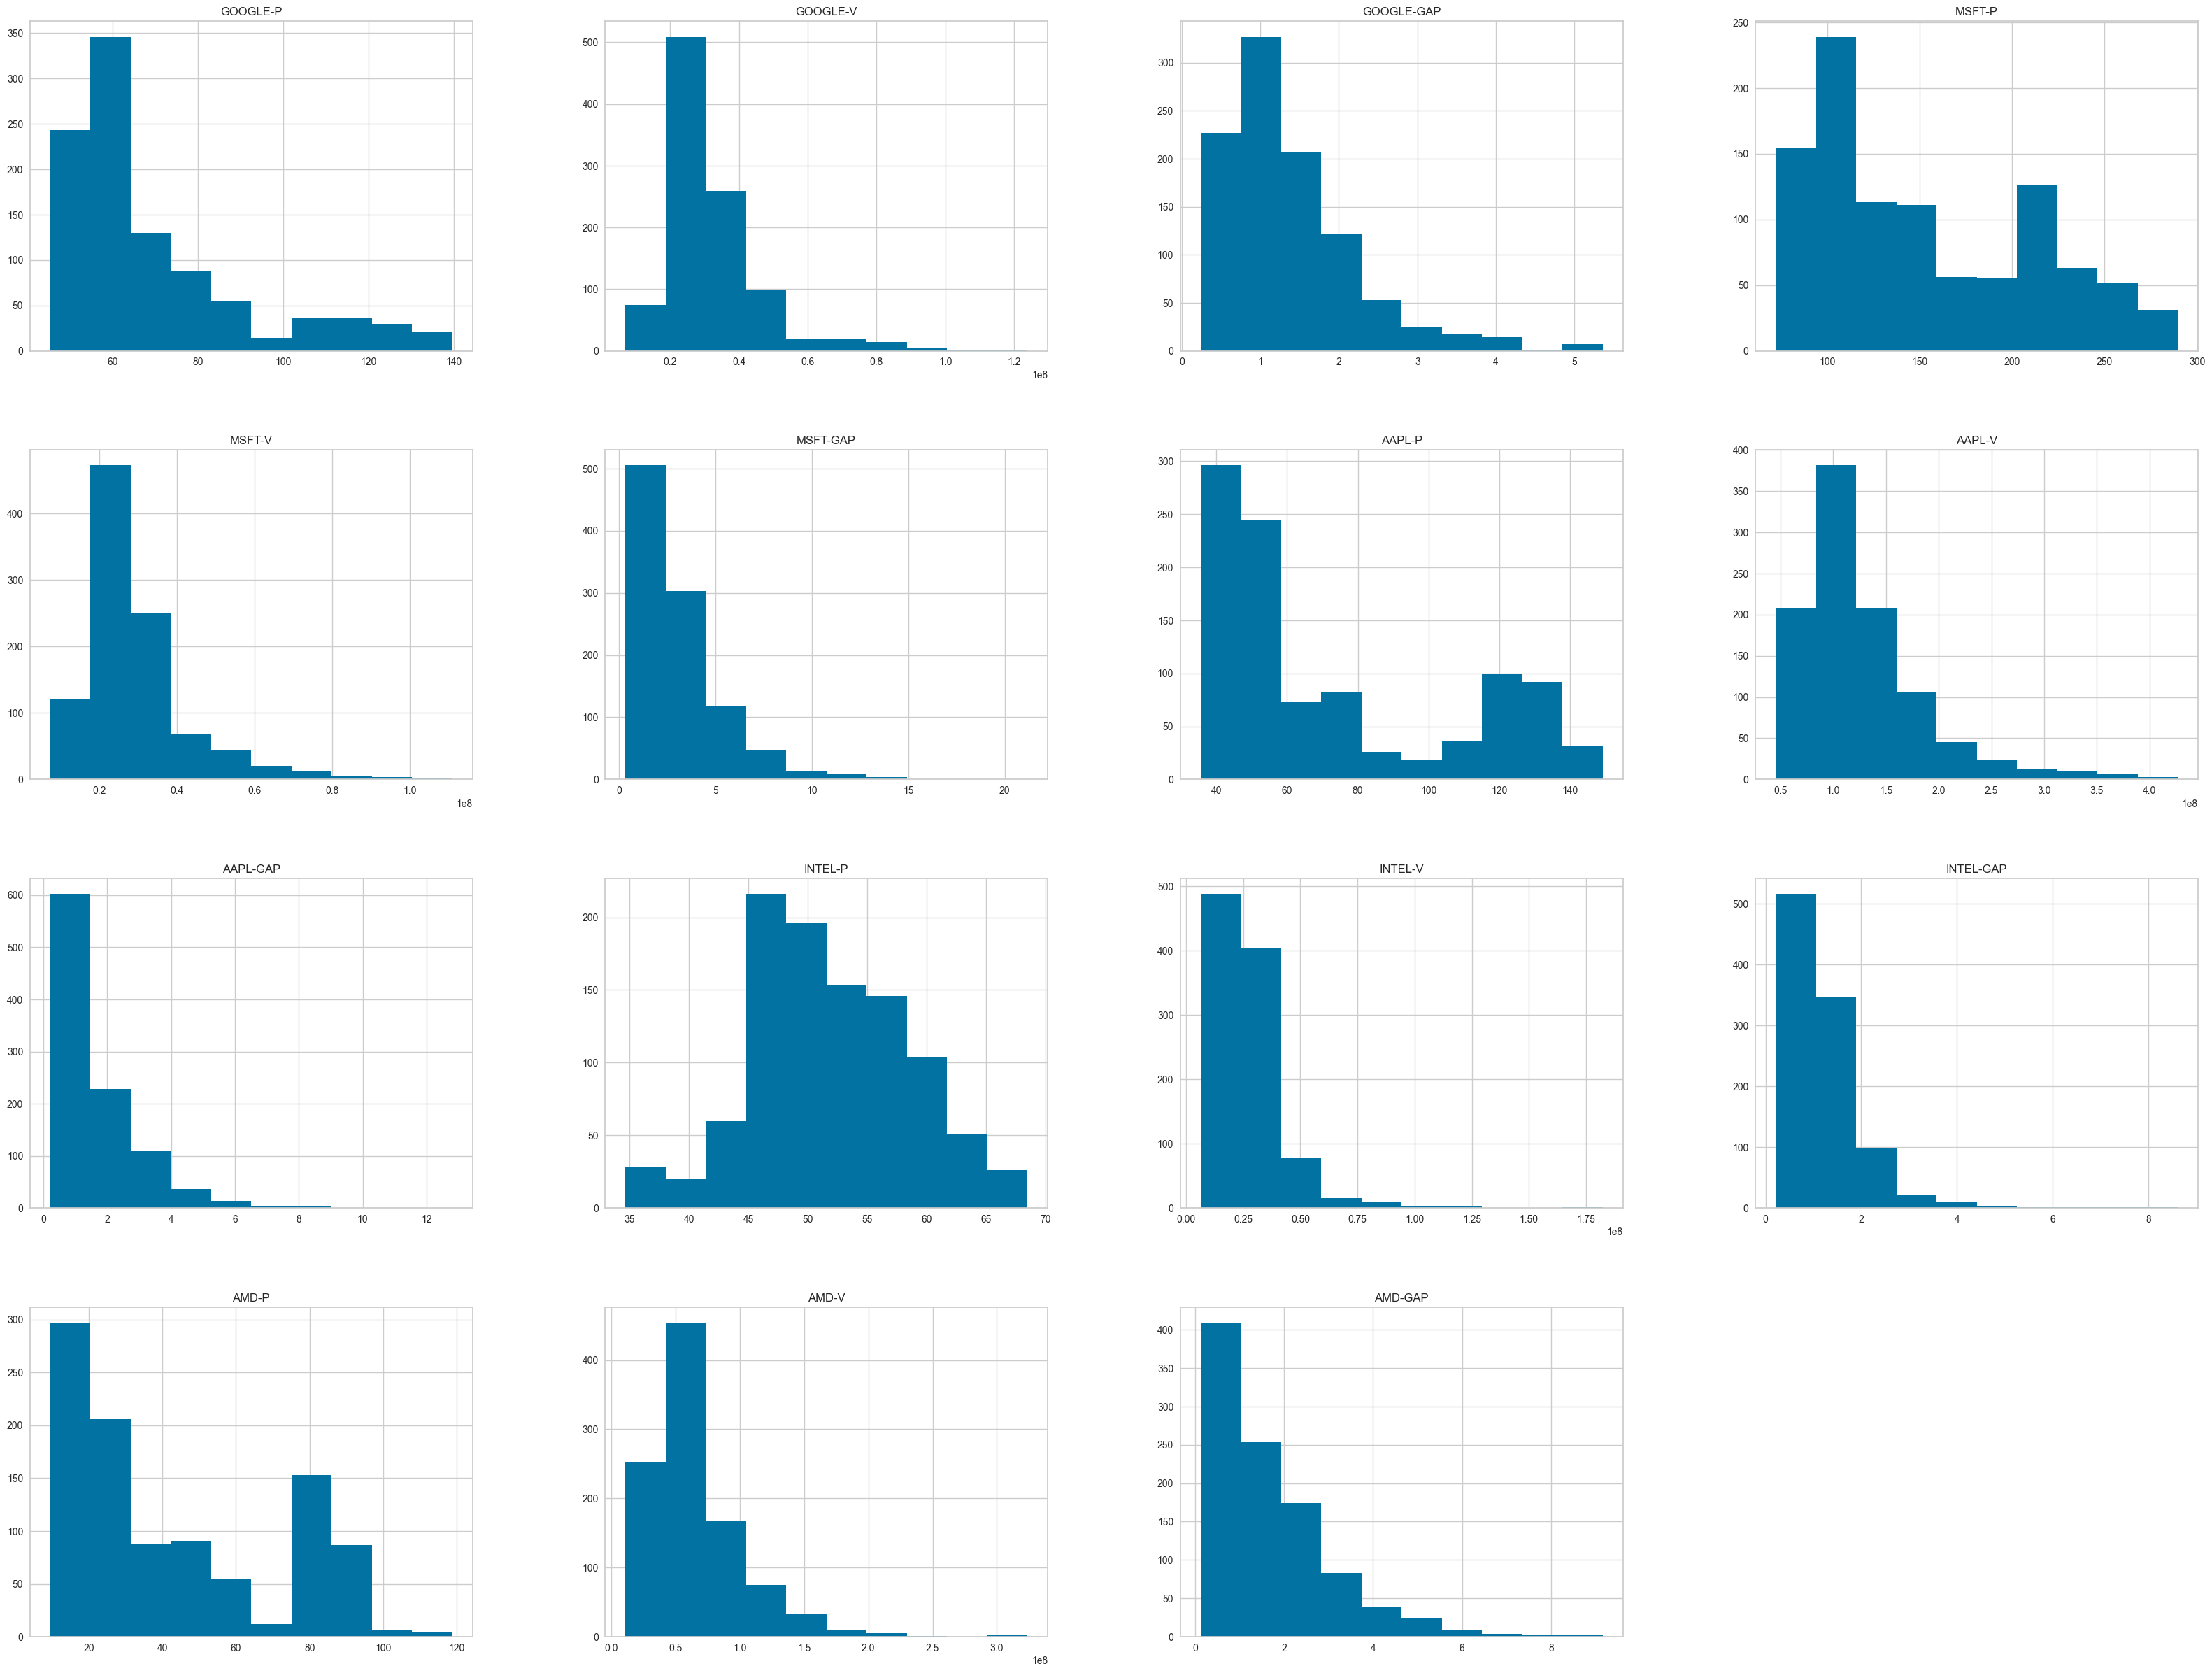

In [28]:
X_train.hist(figsize=(40,30));

Vemos que INTEL-P sigue una clara distribución gaussiana.

#### Normalizamos los datos a la escala [0-1]

In [29]:
scaler = MinMaxScaler()

X_train_s = scaler.fit_transform(X_train.to_numpy())
X_test_s  = scaler.transform(X_test.to_numpy())

#### Generamos los datos y obtenemos ventanas de longitud 3 mediante la función de sliding_window_view

En este caso obtendré las matrices a i b, respectivamente del conjunto de entrenamiento y test, que me permitem generar los datos. 

* **La matriz a, tendrá la forma de: (997, 15, 4)**
* **La matriz b, tendrá la forma de: (256, 15, 4)**

He decidido, obtiener una ventana de longitud w+1, y es por eso que tenemos estas formas, pero podria haber obtado por no construirla, en ese caso, la matriz a i b, tendrían por valores: 

* **La matriz a, tendria la forma de: (998, 15, 3)**
* **La matriz b, tendria la forma de: (257, 15, 3)**

Después de aplicar el reshape perdemos un dimensión, obteniendo:

* **La matriz 2D X_train_w con unas dimensiones de: (997, 60)**
* **La matriz 2D X_test_w con unas dimensiones de: (256, 60)**

In [30]:
w = 3

a = sliding_window_view(X_train_s, w+1, axis=0).copy()
windows_train = [np.transpose(a[i]) for i in range(len(a))]
X_train_w = np.array(windows_train).reshape(-1,60) # w0 - 15 + 15 + 15 -> 15 (w+1)

b = sliding_window_view(X_test_s, w+1, axis=0).copy()
windows_test = [np.transpose(b[i]) for i in range(len(b))]
X_test_w = np.array(windows_test).reshape(-1,60)

Decido generar una última ventana de longitud w+1, esta última columna que contendrá el valor a predecir con los w elementos de la ventana

In [31]:
print(X_train_w.shape, X_test_w.shape)

(997, 60) (256, 60)


#### Construimos la que será nuestra variable target 

Para construir esta variables, nos fijaremos en la variable del precio de las acciones de Google. Esta nos permitirá generar nuestro target que indicará si el valor subió o bajó respecto al día anterior. Es por este motivo que aquí usaremos nuestras ventanas y comparándos los valores del precio de las acciones de Google según si el precio del día de después(tercera ventana, posición 45) es mayor a la del día anterior, situada en la segunda ventana, posición 30. Lo vemos:

In [32]:
target_y = [None]*X_train_w.shape[0]

for i in range(len(X_train_w[:])):
    #podemos ir jugando con la posición de las variables 30:GOOGLE-P, 31:GOOGLE-V, ... hasta la 44:AMD-GAP
    if(X_train_w[i][30] > X_train_w[i][45]):
        target_y[i] = 0
    else:
        target_y[i] = 1

target = pd.DataFrame(target_y, columns = ['target']) 

X_train_w = pd.DataFrame(X_train_w)
nasdaq_fusion = pd.merge(X_train_w, target, left_index=True, right_index=True)

nasdaq_fusion

0        1        2        3        4        5        6        7  \
0    0.00000  0.10184  0.04725  0.00000  0.09924  0.02111  0.03305  0.15696   
1    0.00956  0.14015  0.09395  0.00464  0.06673  0.02639  0.03871  0.10699   
2    0.01078  0.12685  0.05672  0.00262  0.06118  0.01344  0.03915  0.08405   
3    0.00775  0.15722  0.10328  0.00248  0.09343  0.02159  0.03759  0.08830   
4    0.00489  0.12073  0.05168  0.00308  0.05182  0.02543  0.03889  0.14495   
..       ...      ...      ...      ...      ...      ...      ...      ...   
992  0.95310  0.14552  0.14041  0.97812  0.13060  0.11564  0.97104  0.06552   
993  0.96125  0.11290  0.21730  0.97770  0.08541  0.12932  0.96805  0.04570   
994  0.96433  0.10370  0.37368  0.98828  0.10098  0.13868  0.98424  0.05070   
995  0.96166  0.08201  0.17278  0.98547  0.08468  0.12468  0.98063  0.02863   
996  0.97132  0.04221  0.21710  0.99931  0.06254  0.15307  0.98160  0.00249   

           8        9  ...       51       52       53       54       55  \
0    0.03822  0.00798  ...  0.03759  0.08830  0.02652  0.00177  0.04530   
1    0.02235  0.00000  ...  0.03889  0.14495  0.00865  0.00059  0.04775   
2    0.01461  0.00030  ...  0.04243  0.14983  0.02413  0.00000  0.08177   
3    0.02652  0.00177  ...  0.04560  0.18969  0.04497  0.00237  0.05406   
4    0.00865  0.00059  ...  0.04657  0.16625  0.00845  0.00710  0.06962   
..       ...      ...  ...      ...      ...      ...      ...      ...   
992  0.15929  0.56387  ...  0.98063  0.02863  0.10293  0.56919  0.06422   
993  0.11801  0.56268  ...  0.98160  0.00249  0.11563  0.56889  0.05113   
994  0.21049  0.57392  ...  0.97350  0.02275  0.10054  0.56978  0.07356   
995  0.10293  0.56919  ...  0.97306  0.00907  0.07673  0.57363  0.04749   
996  0.11563  0.56889  ...  0.96875  0.06181  0.17437  0.57037  0.05628   

          56       57       58       59  target  
0    0.01546  0.02719  0.08352  0.02212       0  
1    0.01665  0.02655  0.05951  0.02212       0  
2    0.00000  0.02472  0.07765  0.02987       0  
3    0.01011  0.02398  0.07182  0.01438       1  
4    0.01427  0.02874  0.10474  0.04425       1  
..       ...      ...      ...      ...     ...  
992  0.06302  1.00000  0.68519  0.90819       0  
993  0.02735  0.94123  0.40544  0.66040       1  
994  0.02259  0.92073  0.42474  0.71238       1  
995  0.04400  0.89756  0.33475  0.56969       1  
996  0.07907  0.88750  0.32600  0.51881       1  

[997 rows x 61 columns]

Lo hacemos también para el conjunto de test

In [33]:
target_y_test = [None]*X_test_w.shape[0]

for i in range(len(X_test_w[:])):
    if(X_test_w[i][30] > X_test_w[i][45]):
        target_y_test[i] = 0
    else:
        target_y_test[i] = 1

target_test = pd.DataFrame(target_y_test, columns = ['target']) 

X_test_w = pd.DataFrame(X_test_w)
nasdaq_fusion_test = pd.merge(X_test_w, target_test, left_index=True, right_index=True)

nasdaq_fusion_test

0        1        2        3        4        5        6        7  \
0    0.97927  0.07075  0.24594  0.98750  0.06308  0.11804  0.97104  0.00798   
1    0.98669  0.06596  0.27353  1.00064  0.06902  0.15787  0.99771  0.07427   
2    0.98687  0.04827  0.08415  1.01462  0.10455  0.15643  0.99956  0.03651   
3    0.99228  0.09504  0.50502  1.02266  0.14577  0.21401  1.01734  0.15235   
4    0.97515  0.12260  0.33053  1.01568  0.12220  0.09645  1.00915  0.12265   
..       ...      ...      ...      ...      ...      ...      ...      ...   
251  0.79860  0.11596  0.42601  0.99766  0.16675  0.12140  1.17684  0.06481   
252  0.78980  0.08325  0.49828  0.98782  0.12211  0.20921  1.17024  0.03068   
253  0.81980  0.07854  0.39280  1.01030  0.14678  0.22217  1.20202  0.05923   
254  0.82224  0.07344  0.28348  1.01747  0.10298  0.17898  1.21162  0.02266   
255  0.81832  0.07431  0.28399  1.01398  0.10314  0.15739  1.21021  0.02865   

           8        9  ...       51       52       53       54       55  \
0    0.07752  0.57629  ...  1.01734  0.15235  0.35776  0.55648  0.06467   
1    0.23788  0.55855  ...  1.00915  0.12265  0.18866  0.53341  0.08924   
2    0.07628  0.55707  ...  0.97544  0.10717  0.34585  0.51863  0.04972   
3    0.35776  0.55648  ...  0.97843  0.10883  0.26091  0.52602  0.09483   
4    0.18866  0.53341  ...  0.99155  0.03959  0.11960  0.51331  0.11034   
..       ...      ...  ...      ...      ...      ...      ...      ...   
251  0.17676  0.02129  ...  1.21162  0.02266  0.14540  0.04997  0.10848   
252  0.20533  0.02779  ...  1.21021  0.02865  0.14565  0.04554  0.10620   
253  0.20295  0.04317  ...  1.22359  0.08938  0.26726  0.03341  0.12993   
254  0.14540  0.04997  ...  1.22007  0.04415  0.12436  0.04583  0.10392   
255  0.14565  0.04554  ...  1.19691  0.06527  0.17595  0.02158  0.14272   

          56       57       58       59  target  
0    0.03329  0.89665  0.19937  0.61892       1  
1    0.08899  0.89738  0.20146  0.35730       0  
2    0.08442  0.85967  0.21851  0.51770       0  
3    0.10464  0.86205  0.19207  0.45188       1  
4    0.08918  0.87074  0.14127  0.20686       1  
..       ...      ...      ...      ...     ...  
251  0.06064  0.83742  0.16077  0.21347       1  
252  0.07907  0.83001  0.15724  0.33295       0  
253  0.07075  0.81234  0.16847  0.30918       0  
254  0.06540  0.83220  0.20787  0.46635       1  
255  0.07432  0.79110  0.17962  0.50166       0  

[256 rows x 61 columns]

#### Vemos el patrón que seguimos en el conjunto de datos de entrenamiento:

Antes sin transponer la matriz no obteníamos el resultado correcto

**Si nos fijamos para la columna 15 los primeros 10 días: tenemos 0 1 2 3 ...** </br>
**Si nos fijamos para la columna 30 los primeros 10 días: tenemos 1 2 3 4 ...**   
**Si nos fijamos para la columna 45 los primeros 10 días: tenemos 2 3 4 5 ...**

In [34]:
print(X_train_w[15][:10])
print(X_train_w[30][:10])
print(X_train_w[45][:10])
y_train_w = target
y_train_w

0    0.00956
1    0.01078
2    0.00775
3    0.00489
4    0.00379
5    0.00776
6    0.01215
7    0.01732
8    0.01627
9    0.01155
Name: 15, dtype: float64
0    0.01078
1    0.00775
2    0.00489
3    0.00379
4    0.00776
5    0.01215
6    0.01732
7    0.01627
8    0.01155
9    0.01121
Name: 30, dtype: float64
0    0.00775
1    0.00489
2    0.00379
3    0.00776
4    0.01215
5    0.01732
6    0.01627
7    0.01155
8    0.01121
9    0.01553
Name: 45, dtype: float64


target
0         0
1         0
2         0
3         1
4         1
..      ...
992       0
993       1
994       1
995       1
996       1

[997 rows x 1 columns]

#### Vemos el patrón que seguimos en el conjunto de datos de test:

In [35]:
print(X_test_w[15][:10])
print(X_test_w[30][:10])
print(X_test_w[45][:10])
y_test_w = target_test
y_test_w

0    0.98669
1    0.98687
2    0.99228
3    0.97515
4    0.96740
5    0.97104
6    0.98720
7    1.01543
8    1.02920
9    1.03505
Name: 15, dtype: float64
0    0.98687
1    0.99228
2    0.97515
3    0.96740
4    0.97104
5    0.98720
6    1.01543
7    1.02920
8    1.03505
9    1.02628
Name: 30, dtype: float64
0    0.99228
1    0.97515
2    0.96740
3    0.97104
4    0.98720
5    1.01543
6    1.02920
7    1.03505
8    1.02628
9    1.05202
Name: 45, dtype: float64


target
0         1
1         0
2         0
3         1
4         1
..      ...
251       1
252       0
253       0
254       1
255       0

[256 rows x 1 columns]

#### Eliminamos la cuarta ventana w+1

In [36]:
X_train_w = X_train_w.drop(list(range(45,60,1)), axis=1)
X_test_w  = X_test_w.drop(list(range(45,60,1)), axis=1)

#### Vemos la forma final de nuestros conjuntos de datos

Depeniendo del tamaño de la ventana, es claro que nuestro número de muestras de la matriz tridimensional variará.

In [37]:
X_train_w.shape, y_train_w.shape, X_test_w.shape, y_test_w.shape,

((997, 45), (997, 1), (256, 45), (256, 1))

#### Obtenemos en forma de array nuestros valores target, para poder operar de forma más fácil.

In [38]:
y_train_w = y_train_w['target'].values
y_test_w  = y_test_w['target'].values

### Estudio de las características de los datos

#### Calculando sus estadísticas

Podemos ver también la relación que hay entre las variables de las ventanas y el target utilizando la información mutua

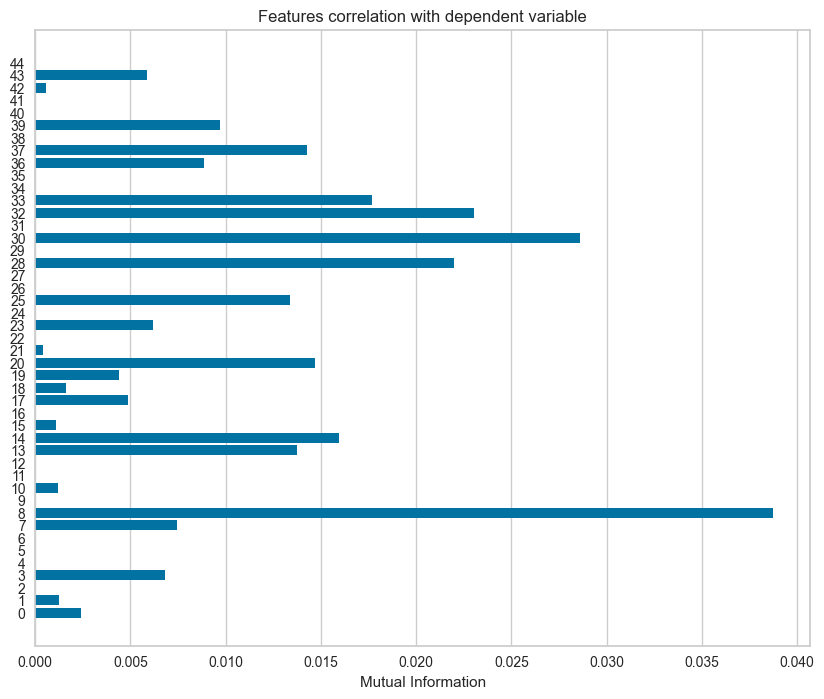

In [39]:
plt.figure(figsize=(10,8))
visualizer = feature_correlation(X_train_w, y_train_w, labels=list(X_train_w.columns),method='mutual_info-classification');

Aquí podemos ver la correlación de las distintas variables predictoras con la variable target que usaremos para predicir si el precio de la acción subirá o no según el dia anterior para la tecnológica GOOGLE, como vemos se le atrtibuye un peso importante al valor de esta que está en la ventana anterior(feature 30). También le atribuye un peso importante al APPLE-GAP de ventanas anterior, que ya veíamos en el heatmap que tenían una cierta correlación.

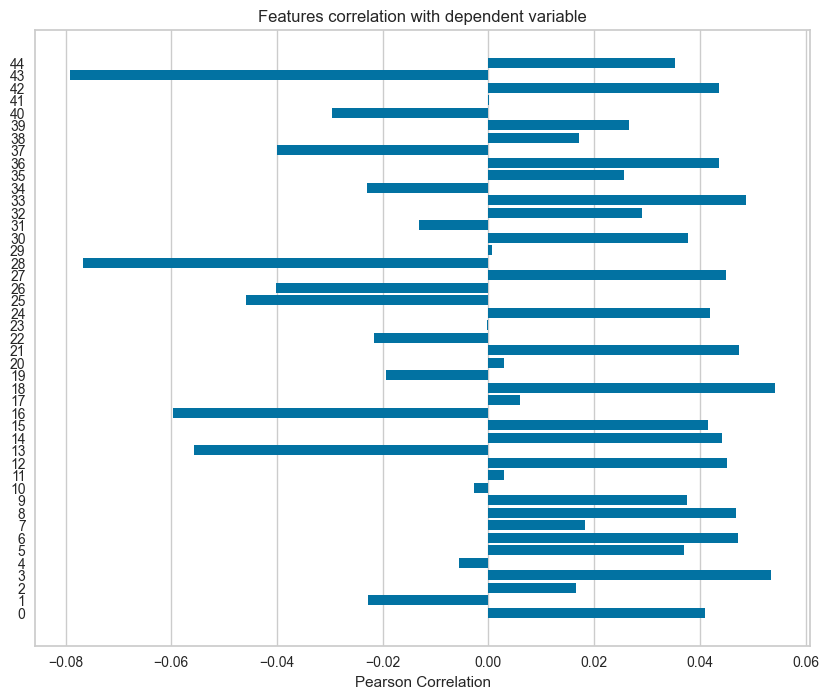

In [40]:
plt.figure(figsize=(10,8))
visualizer = feature_correlation(X_train_w, y_train_w, labels=list(X_train_w.columns),method='pearson');

De forma análoga vemos lo mismo pero ahora usano el método de Pearson, que este le atribuye distintos pesos a cada característica.

#### Relación entre la varible del precio de GOOGLE contra las demás variables:

Como se puede ver, para cada par, variable GOOGLE-P-variable predictora hemos generado un regplot mediante la librería de seaborn.

Como podemos ver cada plot nos muestra dos valores, (r y p), los cuáles son la correlación de ambas varibles mediante el coeficiente de Pearson y el p-valor de este.

Arriba de estos, podemos ver lo mismo usando el método `feature_correlation`

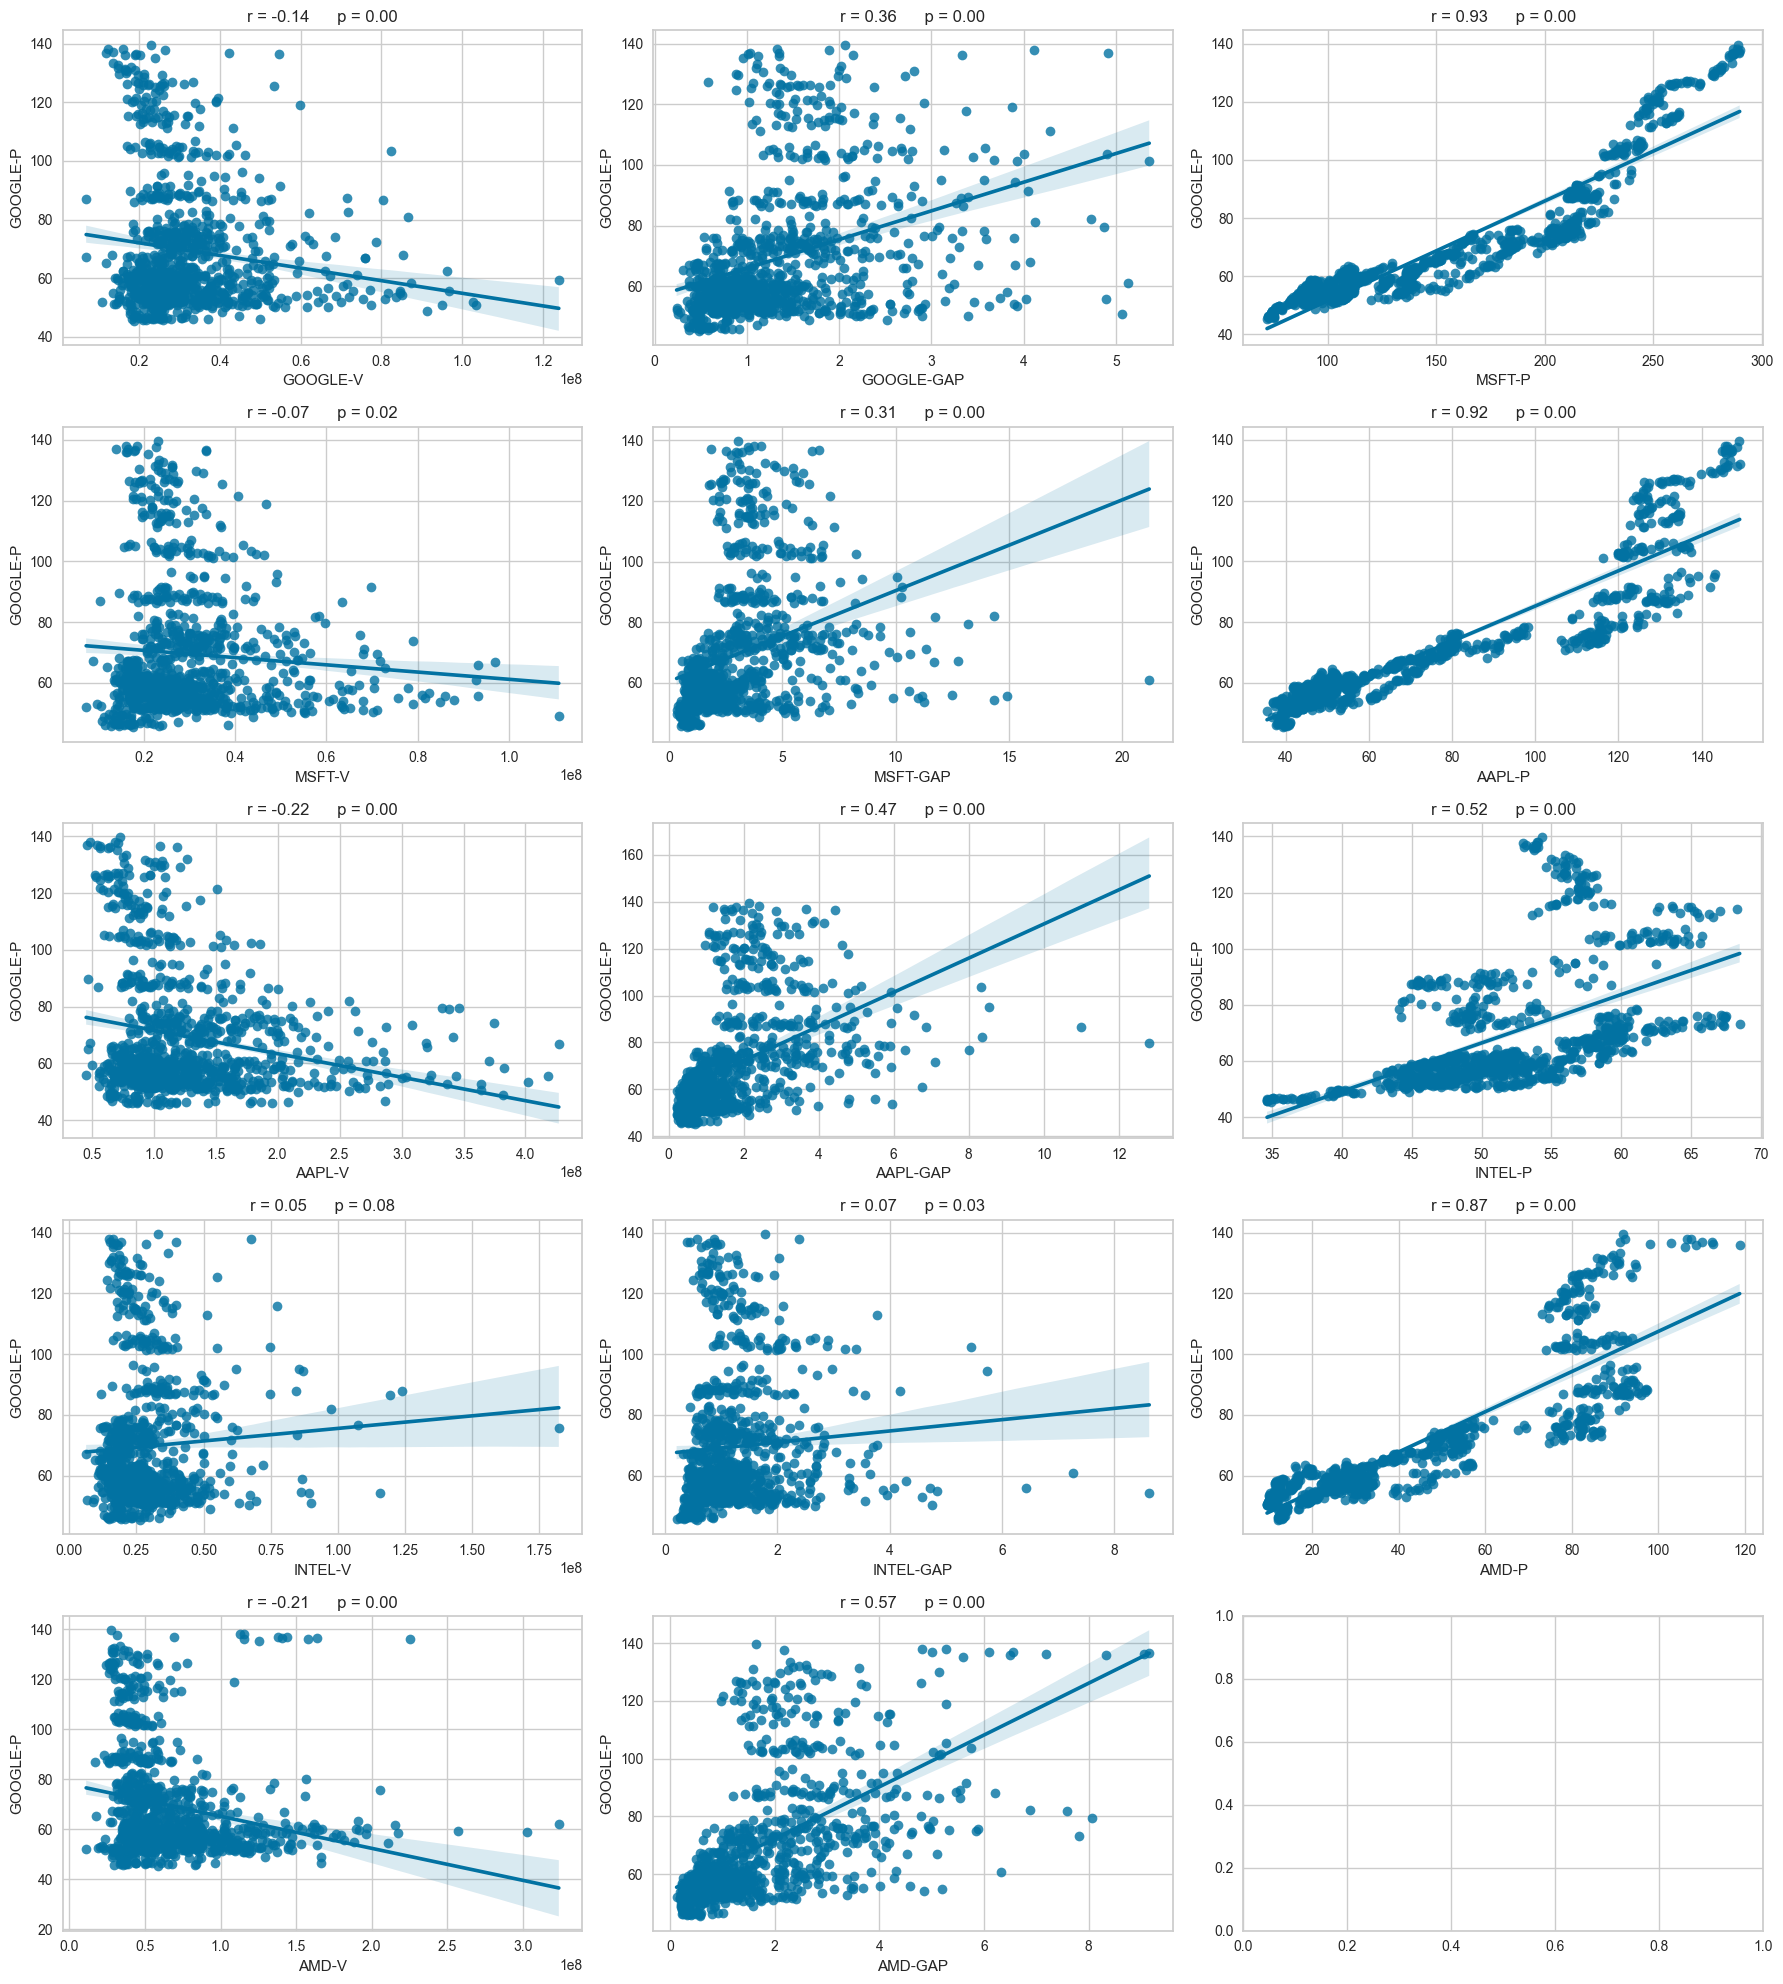

In [41]:
nr_rows = 5
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*6,nr_rows*4))

li_num_feats = list(X_train.columns)
li_plot_num_feats = [c for c in list(X_train.columns[1:])]


for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(x=X_train[li_plot_num_feats[i]], y=X_train['GOOGLE-P'], ax = axs[r][c])
            #primer atributo(r) és la correlación, segundo atributo(p) és p-value
            stp = stats.pearsonr(X_train[li_plot_num_feats[i]], X_train['GOOGLE-P'])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=12)
            
plt.tight_layout()    
plt.show()

Vemos que usando este plot, si que se aprecia de forma muy clara la casi correlación positiva perfecta con la variable MSFT-P, y con la variable APPL-P. Quedando atrás la tecnológica AMD, seguida de INTEL

#### Correlación de la variable del precio de Google, contra las demás variables

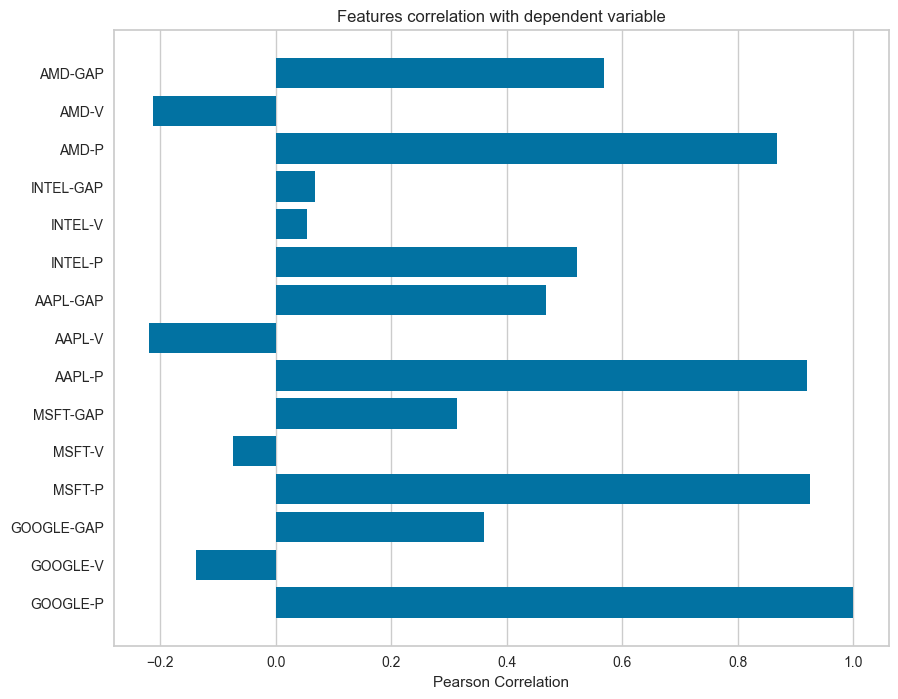

In [42]:
plt.figure(figsize=(10,8))
visualizer = feature_correlation(X_train, X_train['GOOGLE-P'], labels=list(X_train.columns),method='pearson');

Esta representación sigue al heatmap que ya habíamos representado anteriormente. Y dónde en este sacamos las mismas conclusiones. 

Podemos notar que si el precio de las acciones de GOOGLE-P suben, vemos que el volumen de las acciones de AAPL caen. O también como es el volumen de las acciones de AMD, Microsoft i APPLE, lo que hace pensar que tiene toda la lógica del mundo.

También podemos notar que tenemos una correlación cercana a 0 con las variables:

* INTEL-GAP
* INTEL-V
* MSFT-V

Puesto que observamos que no existe casi correlación entre la variables que preceden y la variable GOOGLE-P

#### ¿Crees que puede ser posible predecir unas variables a partir de otras?

En mi sincera opinión creo que no es posible. Como ya he destacado en el apartado: [Correlación variables](#posible-predecir). Usando cualquier variable nos vamos a encontrar un poco en la misma situación. El mercado de valores fluctua tanto que aunque parezca haber relación entre las variables si se da la casualidad que durante uun periodo el precio de la acción siempre se va al alza poco vamos a poder hacer en nuestra predicción cuando nuestro modelo intente generalizar. Estamos ante un problema que al final va ser un poco complicado poder capturar patrones. Si tuvieramos un poco más de días, alomejor podríamos mejorar, pero creo que es un poco complicado poder predecir este caso de clasificación. 

#### Aplicación del PCA con el conjunto de datos generado

In [43]:
X_train_standarized_w = X_train_w.copy()

myPCA = PCA().fit(X_train_standarized_w[X_train_w.columns]);

#PCA.explained_variance_ratio_ para comprender qué porcentaje de varianza explican los datos
print(myPCA.explained_variance_ratio_)
print(myPCA.explained_variance_ratio_.cumsum())

[6.46551663e-01 1.27253627e-01 5.92374500e-02 2.22217674e-02
 1.90880380e-02 1.73333251e-02 1.21402070e-02 1.14224024e-02
 8.24885245e-03 7.72455817e-03 6.54915935e-03 6.34873292e-03
 6.03179823e-03 4.95323026e-03 4.59074125e-03 4.20913377e-03
 3.84736696e-03 3.42723855e-03 3.31687981e-03 2.67472242e-03
 2.59724975e-03 2.41289386e-03 2.20433638e-03 2.07266689e-03
 1.80805458e-03 1.56110192e-03 1.38377444e-03 1.25870466e-03
 1.19767273e-03 1.08946359e-03 9.00913287e-04 8.25239854e-04
 7.62130092e-04 6.90505578e-04 6.42856572e-04 5.71139829e-04
 4.18813902e-04 1.81269447e-04 7.29531062e-05 6.18697913e-05
 4.33630035e-05 2.65244964e-05 2.12145625e-05 1.57729046e-05
 8.62108147e-06]
[0.64655166 0.77380529 0.83304274 0.85526451 0.87435255 0.89168587
 0.90382608 0.91524848 0.92349733 0.93122189 0.93777105 0.94411978
 0.95015158 0.95510481 0.95969555 0.96390469 0.96775205 0.97117929
 0.97449617 0.97717089 0.97976814 0.98218104 0.98438537 0.98645804
 0.9882661  0.9898272  0.99121097 0.99246968

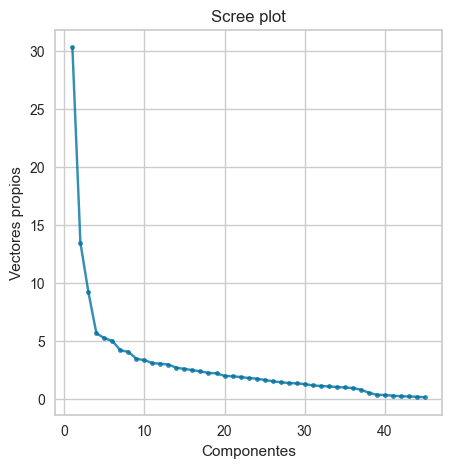

In [44]:
fig = plt.figure(figsize=(5,5));
plt.plot(range(1,len(myPCA.singular_values_ )+1),myPCA.singular_values_ ,alpha=0.8,marker='.');
#La nueva base son los vectores propios de la matriz de covarianza.
y_label = plt.ylabel('Vectores propios');
x_label = plt.xlabel('Componentes');
plt.title('Scree plot');

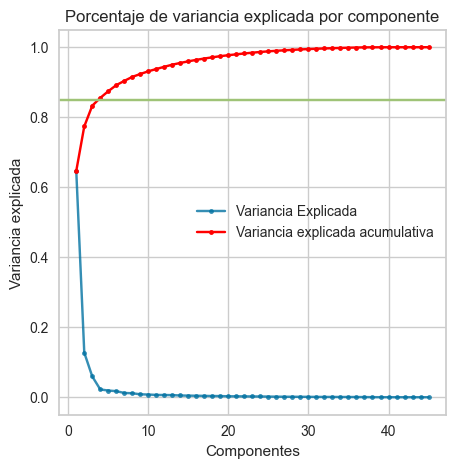

In [45]:
fig = plt.figure(figsize=(5,5));
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),myPCA.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),
         np.cumsum(myPCA.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');
plt.axhline(y=0.85, color='g', linestyle='-')

Podemos ver que la variancia explicada acumulada pasa del 85% a partir del tercer componente, los dos primeros componentes acumulan algo más del 75%.

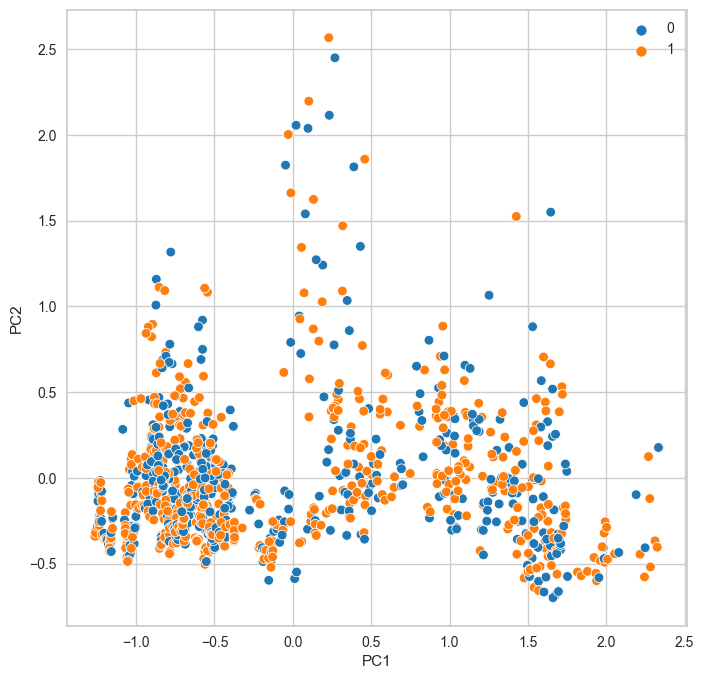

In [46]:
transformed_train = myPCA.transform(X_train_standarized_w[X_train_w.columns])
transformed_train

X_train_standarized_w[['PC1','PC2','PC3']] = transformed_train[:,:3]

fig = plt.figure(figsize=(8,8))
_ = sns.scatterplot(x='PC1', y='PC2', data=X_train_standarized_w, hue=y_train_w, palette='tab10')

In [47]:
import plotly.express as px

fig = px.scatter_3d(X_train_standarized_w, x='PC1', y='PC2', z='PC3',color=y_train_w)
fig.show()

Tanto el PCA com el t-SNE nos ha generado clústeres de ambas etiquetas binarias sin distinguir entre clases, esto nos podría significar que los clústeres no nos representan con precisión las verdaderas etiquetas de clase y que alomejor nos falta una clase en la que nuestro clasificador puede meter los ejemplos que confunde.

A simple vista no queda claro muy bien la separación que está realizando el PCA. Podemo probar de intentar capturar algunas no-linealidades usando el t-SNE

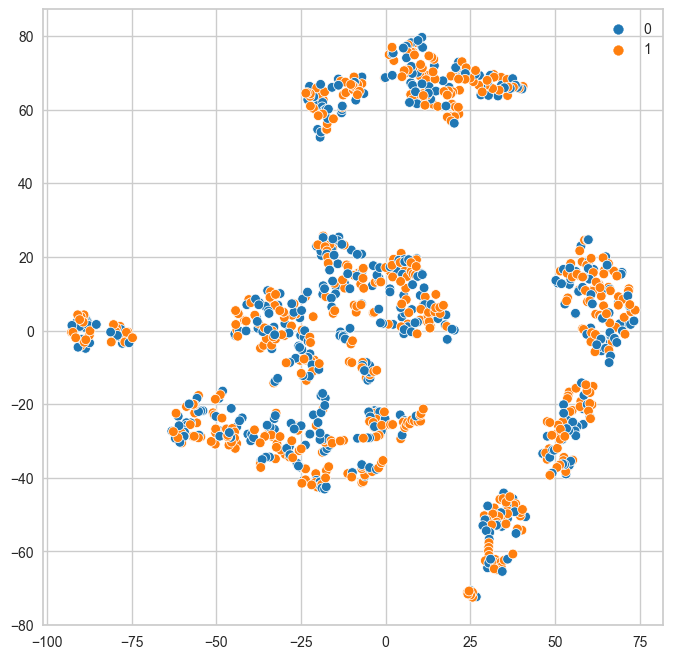

In [48]:
from sklearn.manifold import TSNE

transformed_train = TSNE(n_components=2, perplexity=10, n_iter=2000, init='pca').fit_transform(X_train_standarized_w[X_train_w.columns])

fig = plt.figure(figsize=(8,8))
sns.scatterplot(x=transformed_train[:,0], y=transformed_train[:,1], hue=y_train_w, palette='tab10');

Tampoco, vemos como agrupa valores distintos haciendo que no tengamos una separación de las clases. Probemos con una transformación no lineal como LLE para ver también si hay algun tipo de separabilidad:

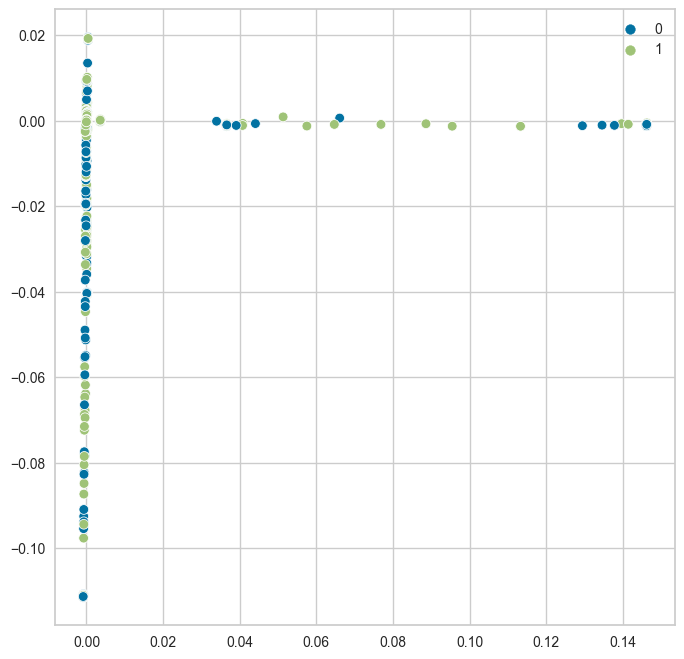

In [50]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=2)
X_trans = lle.fit_transform(X_train_w)

fig = plt.figure(figsize=(8,8))
sns.scatterplot(x=X_trans[:,0], y=X_trans[:,1], hue=y_train_w);

El LLE ha generado una representación en la que todas las etiquetas se colocan en dos líneas pero con los datos fusionados, esto nos puede indicar que este no es capaz de preservar la estructura de los datos.

#### b) Usaremos como modelo base la regresión logística. Ajusta este modelo explorando sus hiperparámetros adecuadamente. Utiliza la exploración bayesiana como hemos hecho en otros ejemplos para poder explorar mejor el espacio de hiperparámetros. Obtén el error de validación cruzada, el error de test, la matriz de confusión, la cursva ROC, y el informe de clasificación.

In [51]:
lr = LogisticRegression(max_iter=100000)
print(np.mean(cross_val_score(lr,X_train_w,y_train_w,cv=10)))

0.5176161616161615


#### Exploración mediante GridSearch

In [52]:
param = {'penalty':['l1', 'l2'],
         'C':[100, 10, 1.0, 0.1, 0.01],
         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
lr_gs =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True, error_score=0.0)
lr_gs.fit(X_train_w, y_train_w);

/usr/local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


150 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to 0.0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: So

In [53]:
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

In [54]:
print(classification_report(lr_gs.predict(X_test_w), y_test_w, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.52      0.68       256

    accuracy                           0.52       256
   macro avg       0.50      0.26      0.34       256
weighted avg       1.00      0.52      0.68       256



/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



Como podemos ver, nos salta un error de `zero_division`, esto se debe a que como podemos ver tenemos un suport de 0 para la clase que nos dice si el precio ha bajado.

En un informe de clasificación, el support se refiere al número de muestras de la respuesta verdadera que se encuentran en esa clase. Si el soporte de una clase es cero, significa que no hay muestras de la respuesta verdadera asignadas a esa clase. Esto nos ocurre ya que el clasificador no es capaz de predecir la clase. Nos podría suceder que pasara si la clase no estuviese presente en los datos de entrenamiento, pero esto no es cierto ya que tenemos valores de 0 en la variable target y el clasificador si que podria generalizar a ella.

Probando de usar otro scaler, lo que sucede es qie el clasificador cambia pocas muestras de la clase 1 a la clase 0, haciendo que el suport no sea 0. Esto sucede debido a la naturaleza del conjunto de test del precio de las acciones de google. Como se ve:   

In [55]:
nasdaq_data['GOOGLE-P'].loc[:1000].iplot(fill=True,colors=['blue'])

In [56]:
nasdaq_data['GOOGLE-P'].loc[1000:].iplot(fill=True,colors=['blue'])

En este problema del NASDAQ, lo que sucede es que el conjunto de test tiene una tendencia diferente a la del conjunto de entrenamiento. En nuestro problema solo hemos considerado dos tendencias, o bien alcista(1) o bajista(0). Pero podriamos llegar a tener otra clase, que fuese **tendencia neutral** aunque aquí el problema recae en la gran diferencia del conjunto de test y de entrenamiento ya que el modelo no es capaz de generalizar y saber que esta sucediendo. 

Debido a que el clasificador no es capaz de predecir ningún ejemplo bajista el soporte se queda a cero para la clase que el precio baja al dia siguiente(0).

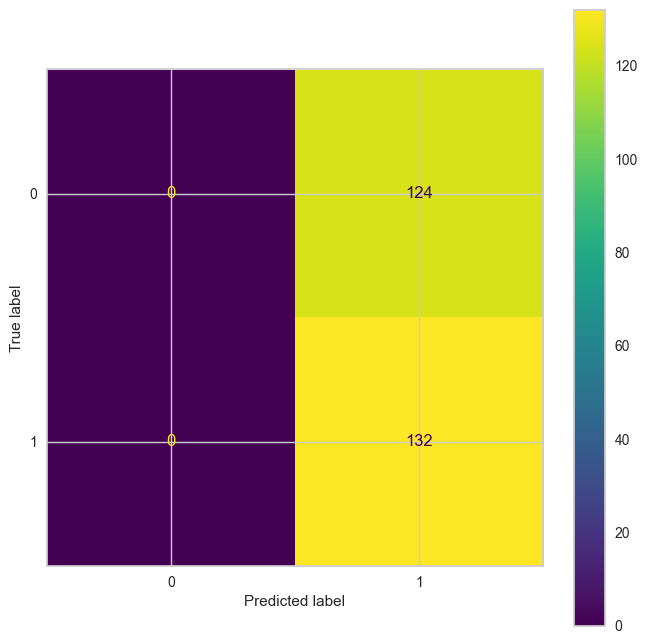

In [57]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test_w, y_test_w, display_labels=['0','1'], ax=plt.subplot());

Vemos que todo lo clasifica como que acoge una tendencia alcista.

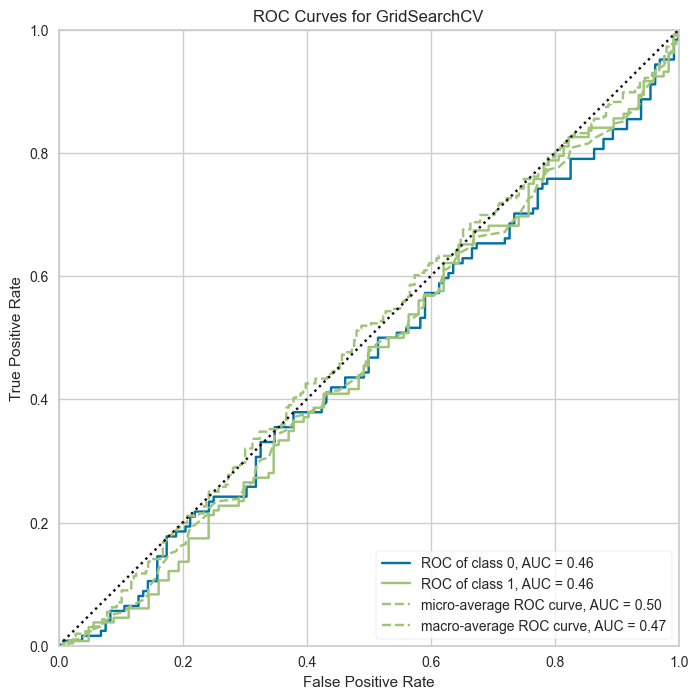

In [58]:
plt.figure(figsize=(8,8));
roc_auc(lr_gs, X_train_w, y_train_w, X_test_w, y_test_w, classes=['0','1']);

Las dos clases tienen una área bajo la curva (AUC) de 0,46 lo que nos indica que el clasificador no está funcionando muy bien. El AUC es una medida de la precisión del clasificador, y un AUC de 0,5 indica un clasificador random. Un AUC de 0,46 está cerca de 0,5, lo que nos indica que nueestro clasificador no es mucho mejor que un clasificador aleatorio.

#### Importancia de los atributos

In [59]:
c = choice(X_test_w.shape[0], size=200, replace=False)
pi = permutation_importance(lr_gs, X_test_w.to_numpy()[c], y_test_w[c], n_jobs=-1, random_state=42)
var_imp = pd.DataFrame({'importance': pi.importances_mean}, index=X_train_w.columns[:])

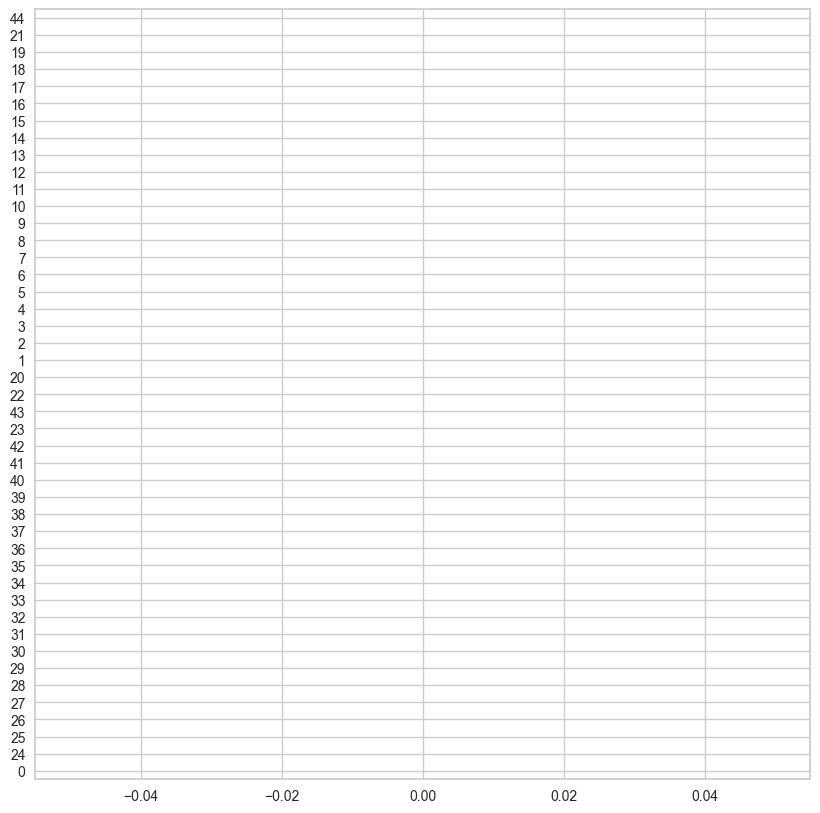

In [60]:
var_imp.sort_values(by='importance').plot.barh(figsize=(10,10), legend=False);

Si cada atributo tiene una importancia de cero al utilizar `permutation importance` para evaluar la importancia de cada feature de un clasificador, significa que las predicciones del clasificador no son sensibles a las permutaciones aleatorias de los valores de ninguno de los atributos. Esto nos indica que los atributos no son útiles para predecir nuestro target y que el clasificador no utiliza la información de los atributos para realizar sus predicciones.

#### Exploración bayesiana

Usando la exploración bayesiana, llegamos a las mismas conclusiones que usando el método de GridSearchCV. Vemos que hemos obtenido

Para el tunning de parametros: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [61]:
param = {'penalty':['l2','l1'],
         'C':[10000, 1000, 100, 10, 1.0, 0.1, 0.01, 0.001],
         'solver': ['lbfgs', 'liblinear', 'saga'] #'newton-cg', 'newton-cholesky', 'sag', 
        }

lr = LogisticRegression(max_iter=100000,random_state=42, verbose=False)
lr_bs = BayesSearchCV(lr,param,n_iter=10, 
                        cv=TimeSeriesSplit(n_splits=10, gap=w+1), 
                        scoring=make_scorer(mean_squared_error, greater_is_better=False),
                        n_jobs=-1, 
                        refit=True, random_state=42)         
lr_bs.fit(X_train_w, y_train_w);

In [62]:
show_html(pd.DataFrame(lr_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

In [63]:
print(classification_report(lr_bs.predict(X_test_w), y_test_w, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.52      0.68       256

    accuracy                           0.52       256
   macro avg       0.50      0.26      0.34       256
weighted avg       1.00      0.52      0.68       256



/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



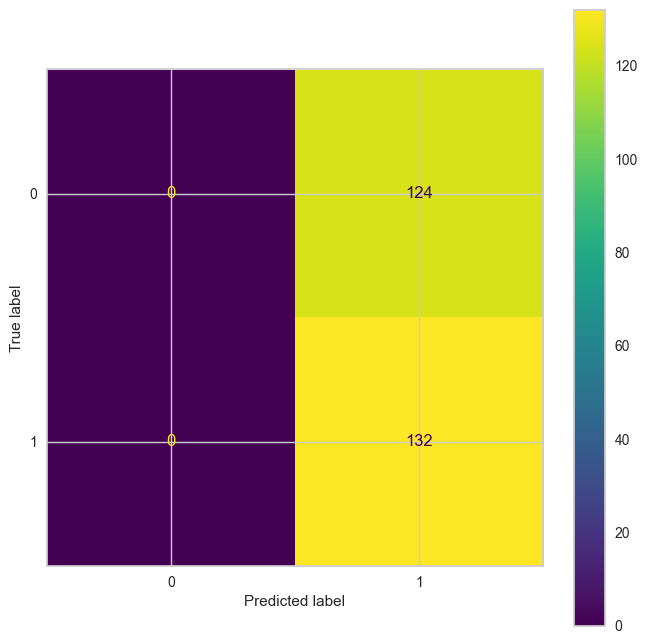

In [64]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_bs, X_test_w, y_test_w, display_labels=['0','1'], ax=plt.subplot());

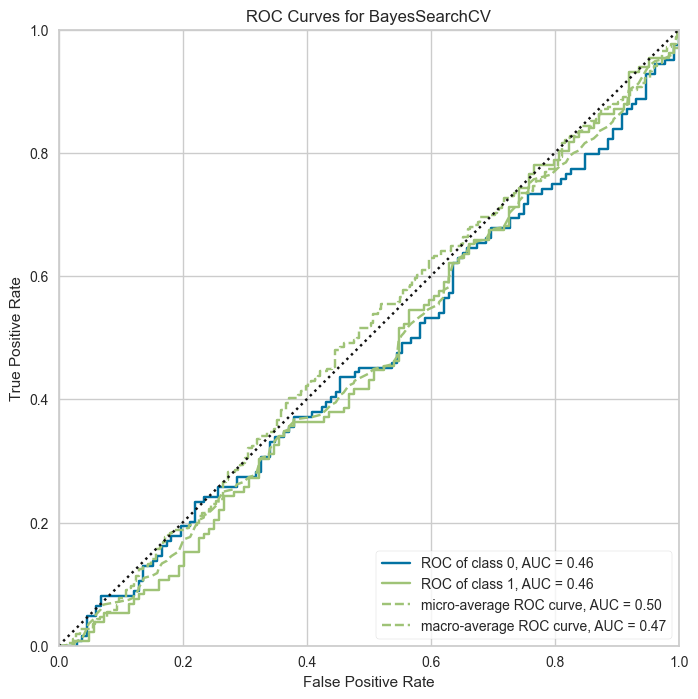

In [65]:
plt.figure(figsize=(8,8));
roc_auc(lr_bs, X_train_w, y_train_w, X_test_w, y_test_w, classes=['0','1']);

In [66]:
c = choice(X_test_w.shape[0], size=200, replace=False)
pi = permutation_importance(lr_gs, X_test_w.to_numpy()[c], y_test_w[c], n_jobs=-1, random_state=42)
var_imp = pd.DataFrame({'importance': pi.importances_mean}, index=X_train_w.columns[:])

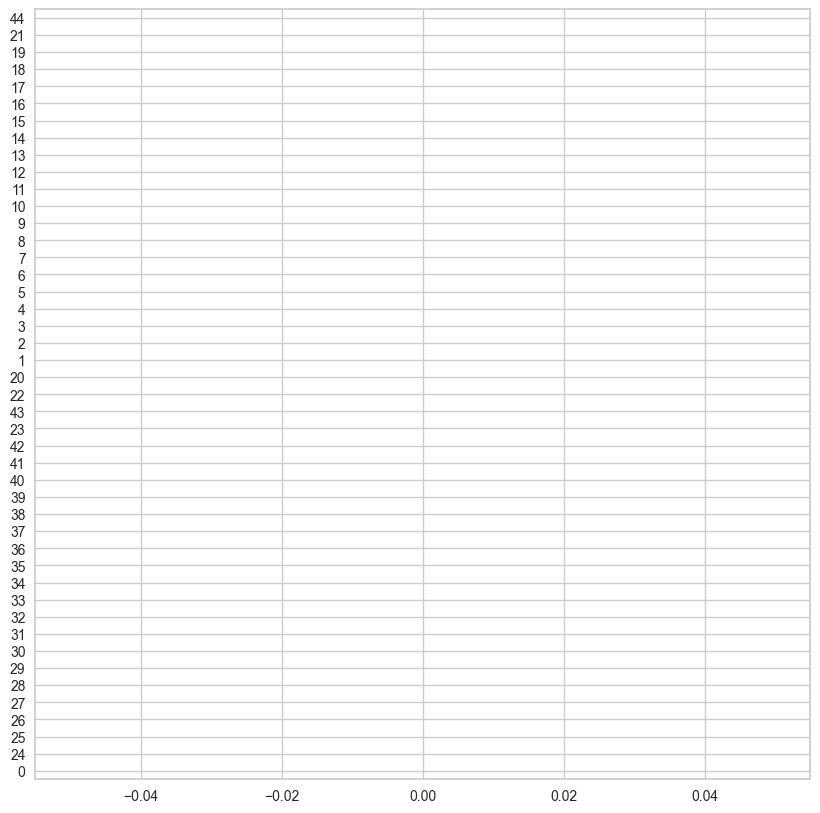

In [67]:
var_imp.sort_values(by='importance').plot.barh(figsize=(10,10), legend=False);

Ídem a la reflexión anterior.

#### c) Ajusta ahora un MLP explorando sus hiperparámetros adecuadamente. Usa también la exploración bayesiana. Obtén el error de validación cruzada, el error de test, la matriz de confusión, la cursva ROC, y el informe de clasificación. Comenta

Para el tunning de parametros: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [68]:
mlp = MLPClassifier(max_iter=2500000,random_state=42, verbose=False, early_stopping=True)
print(np.mean(cross_val_score(mlp,X_train_w,y_train_w,cv=10)))

0.5536666666666666


In [69]:
param = {'hidden_layer_sizes':[10, 50, 100, 200, 300, 400, 500], 
         'activation':['logistic', 'relu', 'tanh', 'identity'], 
         'alpha':[0.00001, 0.0001, 0.001, 0.01],
         'momentum': [0.99, 0.95, 0.90, 0.85],
         'solver': ['adam', 'lbfgs', 'sgd'],
         'learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
         'n_iter_no_change':[10, 20, 30, 40, 50, 60, 80, 100, 200], 
         'learning_rate': ['constant', 'invscaling', 'adaptive']}

mlp =  MLPClassifier(max_iter=2500000,random_state=42, verbose=False, early_stopping=True)
mlp_bs = BayesSearchCV(mlp,param,n_iter=15, 
                        cv=TimeSeriesSplit(n_splits=10, gap=w+1),
                        n_jobs=-1, 
                        refit=True, random_state=42)    
mlp_bs.fit(X_train_w, y_train_w);

/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [70]:
show_html(pd.DataFrame(mlp_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

In [71]:
print(classification_report(mlp_bs.predict(X_test_w), y_test_w,target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.01      0.50      0.02         2
           1       0.99      0.52      0.68       254

    accuracy                           0.52       256
   macro avg       0.50      0.51      0.35       256
weighted avg       0.98      0.52      0.67       256



Vemos que ahora ya no tenemos el error de `zero division` ya que tenemos un valor del support diferente de 0. Ahora es capaz de poder llegar a decir que para esa clase tiene una precision del 0.01. Esto simplemente es que ha sido capaz de clasificar dado el conjunto de test, que dos ejemplos tenian una tendencia bajista con respecto al día anterior. Por lo tanto nuestro clasificador, sólo hace una predicción positiva verdadera de 100 predicciones positivas para esa clase. A grades rasgos, estamos en el mismo caso anterior en el que aplicábamos una regresión logística, lo que pasa es que ahora el valor de corte ha sido un poco más bajo y ha puesto ese ejemplo en la clase del 0.

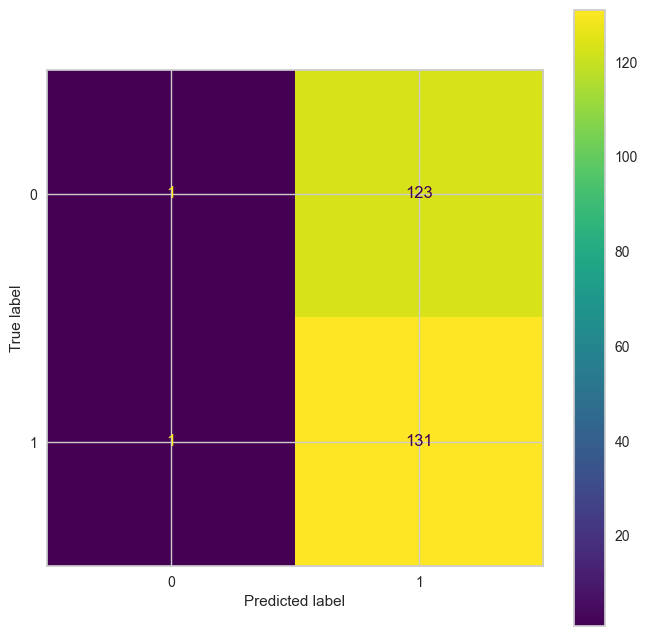

In [72]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(mlp_bs, X_test_w, y_test_w, display_labels=['0','1'], ax=plt.subplot());

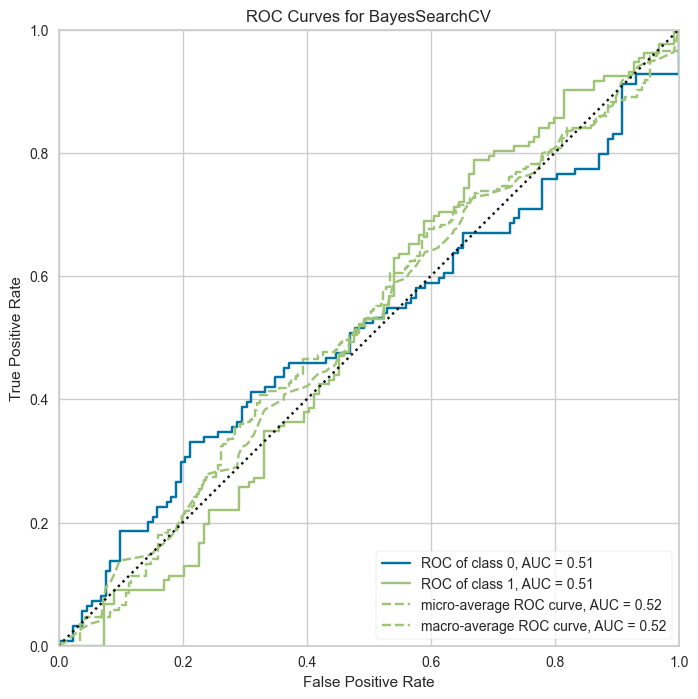

In [73]:
plt.figure(figsize=(8,8));
roc_auc(mlp_bs, X_train_w, y_train_w, X_test_w, y_test_w, classes=['0','1']);

Ahora almenos nuestro clasificador funciona mejor que un clasificador random, ya que tiene una área bajo la curva (AUC) de 0.51. Vaya que nuestro clasificador funciona mejor que un clasificador aleatorio, pero ligeramente.

In [74]:
c = choice(X_test_w.shape[0], size=200, replace=False)
pi = permutation_importance(mlp_bs, X_test_w.to_numpy()[c], y_test_w[c], n_jobs=-1, random_state=42)
var_imp = pd.DataFrame({'importance': pi.importances_mean}, index=X_train_w.columns[:])

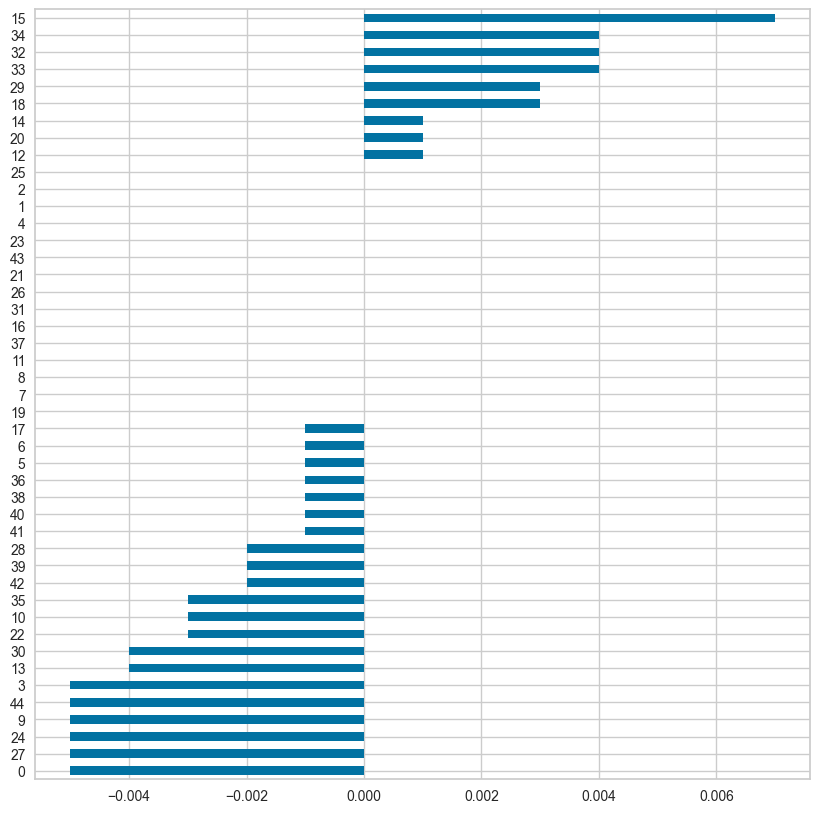

In [75]:
var_imp.sort_values(by='importance').plot.barh(figsize=(10,10), legend=False);

Podemos ver que hay atributos a los que ha atribuido 0 de importancia y que la demás se reparte ligeramente. Sorprende que haya atribuido una importancia negativa al atributo 44, el cuál tiene parte de sentido ya que era una variable que tenía cierta correlación con la variable de GOOGLE-P.

#### d) Quizás el resultado sea diferente si predecimos otra cosa más fácil.Calcula como etiquetas si el volumen de negociación de las acciones de Google sube o no respecto al día anterior y ajusta los mismos modelos que en los apartados anteriores. Compara los resultados de los modelos para este nuevo problema. ¿Hay alguna diferencia con la otra variable? ¿Se te ocurre alguna explicación?

Repetimos el mismo proceso que en el apartado a, pero ahora con la variable de volumen de negociación de las acciones de google, i.e **GOOGLE-V**

In [76]:
X_train = nasdaq_data.iloc[:1000]
X_test  = nasdaq_data.iloc[1000:]

X_train, X_test

X_train.shape, X_test.shape

((1000, 15), (259, 15))

In [77]:
scaler = MinMaxScaler()

X_train_s = scaler.fit_transform(X_train.to_numpy())
X_test_s  = scaler.transform(X_test.to_numpy())

In [78]:
w = 3

a = sliding_window_view(X_train_s, w+1, axis=0).copy()
windows_train = [np.transpose(a[i]) for i in range(len(a))]
X_train_w = np.array(windows_train).reshape(-1,60) # w0 - 15 + 15 + 15 -> 15 (w+1)

b = sliding_window_view(X_test_s, w+1, axis=0).copy()
windows_test = [np.transpose(b[i]) for i in range(len(b))]
X_test_w = np.array(windows_test).reshape(-1,60)

In [79]:
target_y_volumen = [None]*X_train_w.shape[0]

for i in range(len(X_train_w[:])):
    if(X_train_w[i][31] > X_train_w[i][46]):
        target_y_volumen[i] = 0
    else:
        target_y_volumen[i] = 1

target_volumen = pd.DataFrame(target_y_volumen, columns = ['target']) 

X_train_w = pd.DataFrame(X_train_w)
nasdaq_fusion_volumen = pd.merge(X_train_w, target_volumen, left_index=True, right_index=True)

In [80]:
target_y_test_volumen = [None]*X_test_w.shape[0]

for i in range(len(X_test_w[:])):
    if(X_test_w[i][31] > X_test_w[i][46]):
        target_y_test_volumen[i] = 0
    else:
        target_y_test_volumen[i] = 1

target_test_volumen = pd.DataFrame(target_y_test_volumen, columns = ['target']) 

X_test_w = pd.DataFrame(X_test_w)
nasdaq_fusion_test = pd.merge(X_test_w, target_test_volumen, left_index=True, right_index=True)

nasdaq_fusion_test

0        1        2        3        4        5        6        7  \
0    0.97927  0.07075  0.24594  0.98750  0.06308  0.11804  0.97104  0.00798   
1    0.98669  0.06596  0.27353  1.00064  0.06902  0.15787  0.99771  0.07427   
2    0.98687  0.04827  0.08415  1.01462  0.10455  0.15643  0.99956  0.03651   
3    0.99228  0.09504  0.50502  1.02266  0.14577  0.21401  1.01734  0.15235   
4    0.97515  0.12260  0.33053  1.01568  0.12220  0.09645  1.00915  0.12265   
..       ...      ...      ...      ...      ...      ...      ...      ...   
251  0.79860  0.11596  0.42601  0.99766  0.16675  0.12140  1.17684  0.06481   
252  0.78980  0.08325  0.49828  0.98782  0.12211  0.20921  1.17024  0.03068   
253  0.81980  0.07854  0.39280  1.01030  0.14678  0.22217  1.20202  0.05923   
254  0.82224  0.07344  0.28348  1.01747  0.10298  0.17898  1.21162  0.02266   
255  0.81832  0.07431  0.28399  1.01398  0.10314  0.15739  1.21021  0.02865   

           8        9  ...       51       52       53       54       55  \
0    0.07752  0.57629  ...  1.01734  0.15235  0.35776  0.55648  0.06467   
1    0.23788  0.55855  ...  1.00915  0.12265  0.18866  0.53341  0.08924   
2    0.07628  0.55707  ...  0.97544  0.10717  0.34585  0.51863  0.04972   
3    0.35776  0.55648  ...  0.97843  0.10883  0.26091  0.52602  0.09483   
4    0.18866  0.53341  ...  0.99155  0.03959  0.11960  0.51331  0.11034   
..       ...      ...  ...      ...      ...      ...      ...      ...   
251  0.17676  0.02129  ...  1.21162  0.02266  0.14540  0.04997  0.10848   
252  0.20533  0.02779  ...  1.21021  0.02865  0.14565  0.04554  0.10620   
253  0.20295  0.04317  ...  1.22359  0.08938  0.26726  0.03341  0.12993   
254  0.14540  0.04997  ...  1.22007  0.04415  0.12436  0.04583  0.10392   
255  0.14565  0.04554  ...  1.19691  0.06527  0.17595  0.02158  0.14272   

          56       57       58       59  target  
0    0.03329  0.89665  0.19937  0.61892       1  
1    0.08899  0.89738  0.20146  0.35730       1  
2    0.08442  0.85967  0.21851  0.51770       0  
3    0.10464  0.86205  0.19207  0.45188       1  
4    0.08918  0.87074  0.14127  0.20686       0  
..       ...      ...      ...      ...     ...  
251  0.06064  0.83742  0.16077  0.21347       0  
252  0.07907  0.83001  0.15724  0.33295       1  
253  0.07075  0.81234  0.16847  0.30918       1  
254  0.06540  0.83220  0.20787  0.46635       0  
255  0.07432  0.79110  0.17962  0.50166       1  

[256 rows x 61 columns]

In [81]:
y_train_w = target_volumen
y_train_w

y_test_w = target_test_volumen
y_test_w

target
0         1
1         1
2         0
3         1
4         0
..      ...
251       0
252       1
253       1
254       0
255       1

[256 rows x 1 columns]

In [82]:
X_train_w = X_train_w.drop(list(range(45,60,1)), axis=1)
X_test_w  = X_test_w.drop(list(range(45,60,1)), axis=1)

In [83]:
y_train_w = y_train_w['target'].values
y_test_w  = y_test_w['target'].values

### Estudio de las características de los datos

#### Calculando sus estadísticas

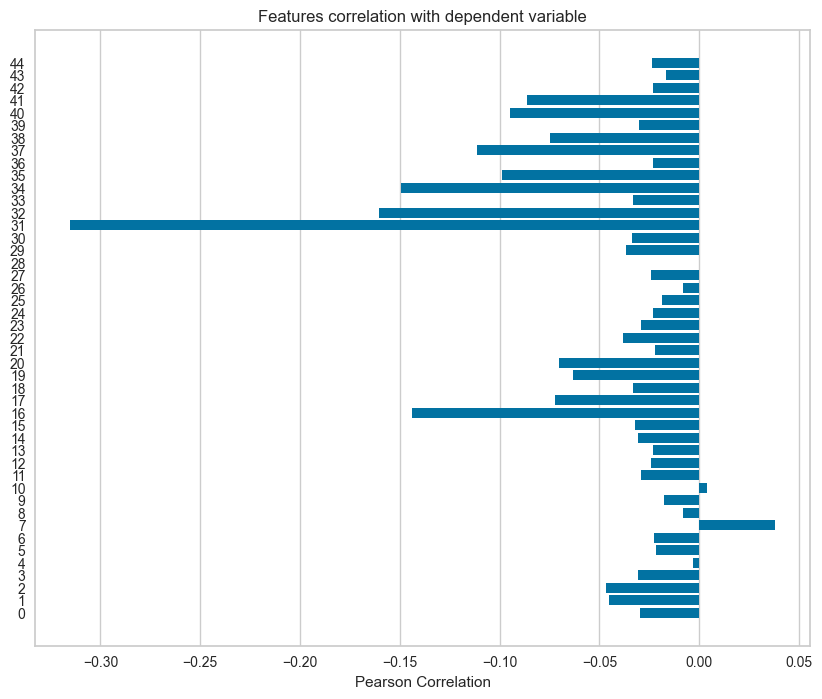

In [84]:
plt.figure(figsize=(10,8))
visualizer = feature_correlation(X_train_w, y_train_w, labels=list(X_train_w.columns),method='pearson');

Vale, vemos que le ha atribuido bastante peso a la variable 31, que precisamente es la variable que hemos usado para poder calcular en efecto el target de la variable nueva que nos indica si el volumen de negociaciones de las acciones de Google o bien tienen una tendencia alcista o bien bajista. 

#### Relación entre la variable del volumen de negociación de GOOGLE contra las demás variables:

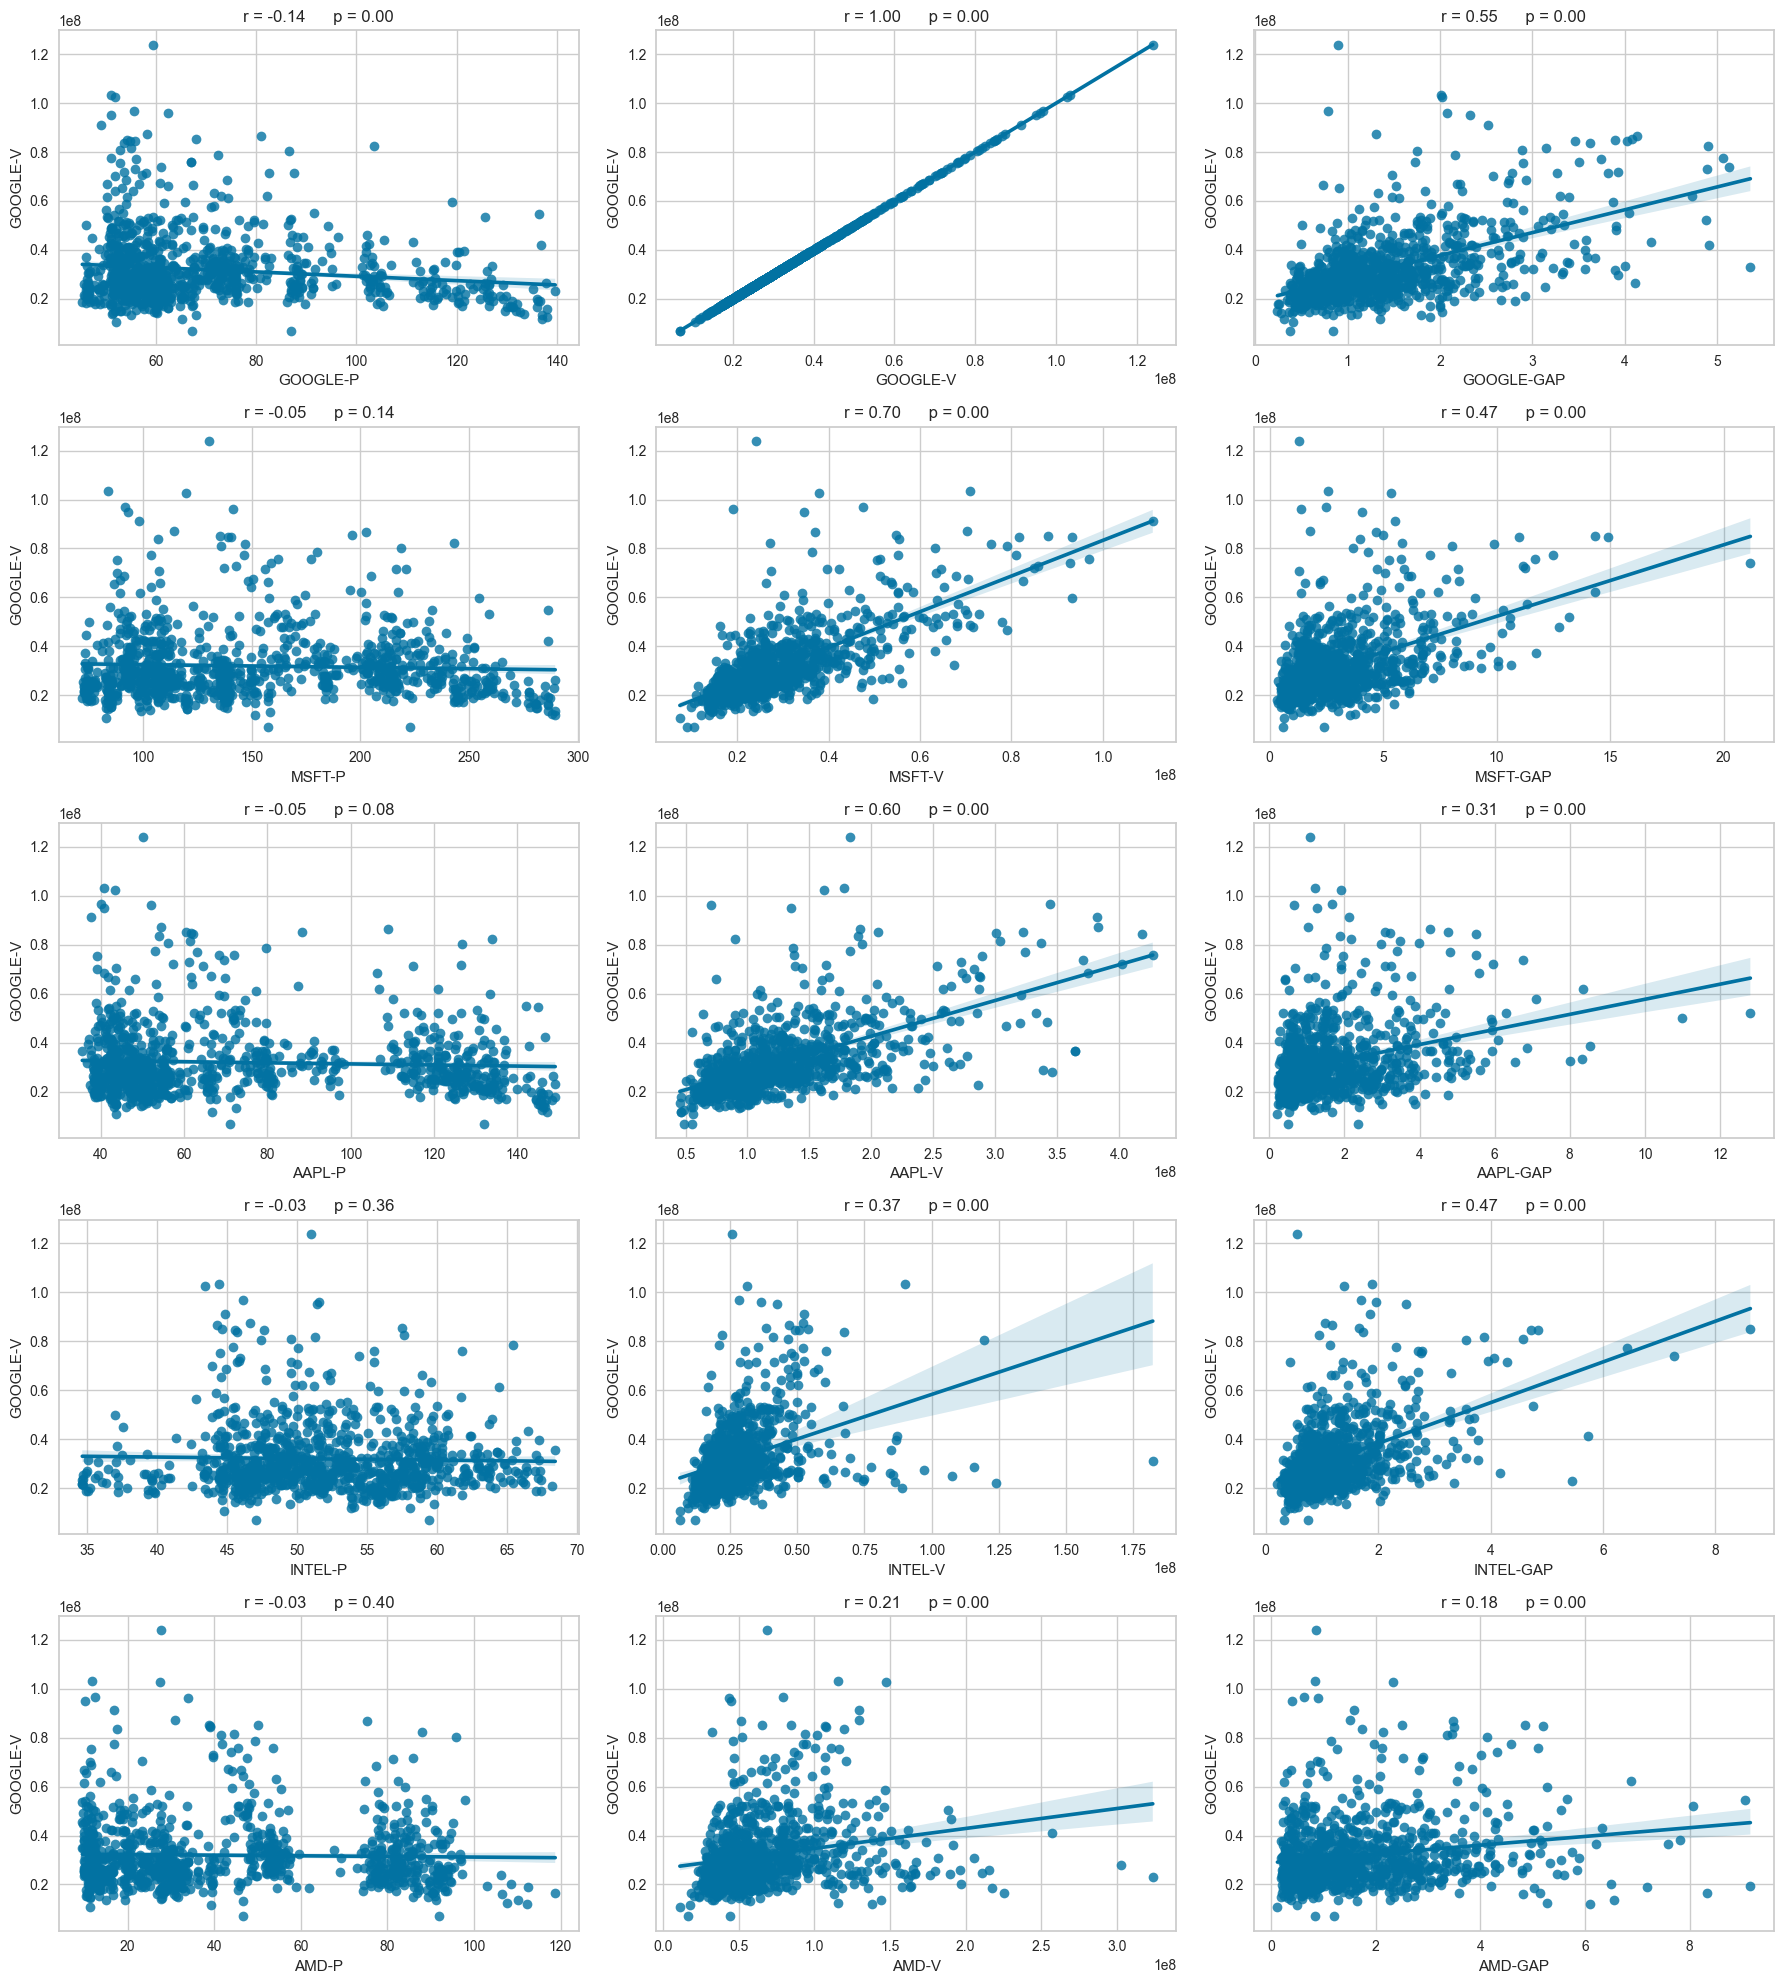

In [85]:
nr_rows = 5
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*6,nr_rows*4))

li_num_feats = list(X_train.columns)
li_plot_num_feats = [c for c in list(X_train.columns[:])]


for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(x=X_train[li_plot_num_feats[i]], y=X_train['GOOGLE-V'], ax = axs[r][c])
            #primer atributo(r) és la correlación, segundo atributo(p) és p-value
            stp = stats.pearsonr(X_train[li_plot_num_feats[i]], X_train['GOOGLE-V'])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=12)
            
plt.tight_layout()    
plt.show()

Vemos que la variable GOOGLE-V tiene unua importante correlación positiva con la variable MSFT-V i APPL-V, seguida del GOOGLE-GAP.

#### Correlación de la variable del precio de Google, contra las demás variables

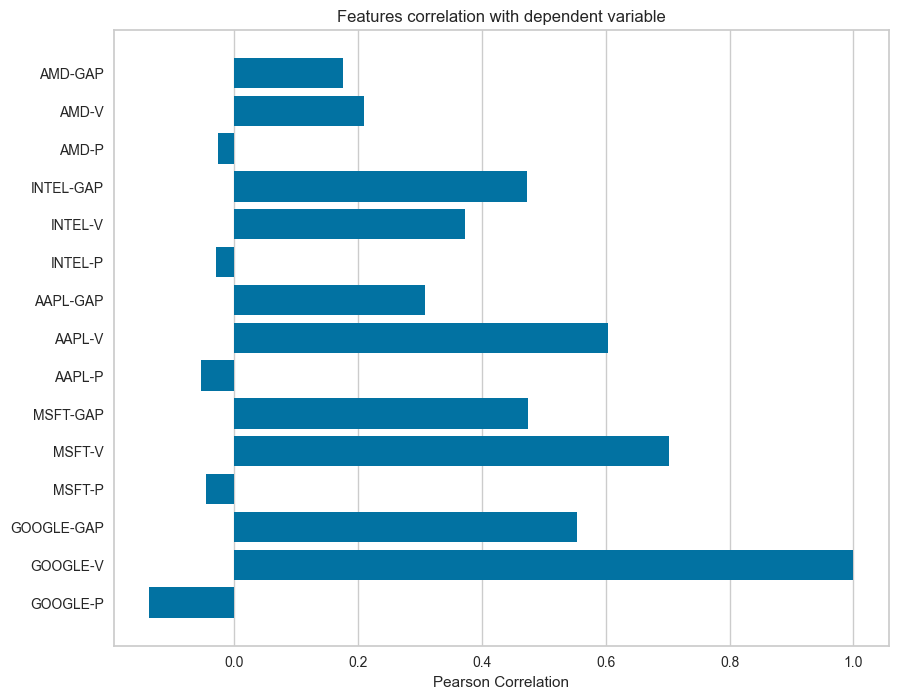

In [86]:
plt.figure(figsize=(10,8))
visualizer = feature_correlation(X_train, X_train['GOOGLE-V'], labels=list(X_train.columns),method='pearson');

Vemos en el gráfico anterior que tiene una perfecta correlación con ella misma(no he quitado la variable del conjunto train para hacer este test). Y además también como veíamos en el gráfico anterior, pero ahora usando barras, el volumen de negociaciones esta correlacionado de forma negativa con el precio de las acciones de las distintas tecnológicas. Esto es lógica ya que si augmenta la demanda, disimuye el precio de la acción en el mercado de valores.

#### Aplicación del PCA con el conjunto de datos generado

In [87]:
X_train_standarized_w = X_train_w.copy()

myPCA = PCA().fit(X_train_standarized_w[X_train_w.columns]);

#PCA.explained_variance_ratio_ para comprender qué porcentaje de varianza explican los datos
print(myPCA.explained_variance_ratio_)
print(myPCA.explained_variance_ratio_.cumsum())

[6.46551663e-01 1.27253627e-01 5.92374500e-02 2.22217674e-02
 1.90880380e-02 1.73333251e-02 1.21402070e-02 1.14224024e-02
 8.24885245e-03 7.72455817e-03 6.54915935e-03 6.34873292e-03
 6.03179823e-03 4.95323026e-03 4.59074125e-03 4.20913377e-03
 3.84736696e-03 3.42723855e-03 3.31687981e-03 2.67472242e-03
 2.59724975e-03 2.41289386e-03 2.20433638e-03 2.07266689e-03
 1.80805458e-03 1.56110192e-03 1.38377444e-03 1.25870466e-03
 1.19767273e-03 1.08946359e-03 9.00913287e-04 8.25239854e-04
 7.62130092e-04 6.90505578e-04 6.42856572e-04 5.71139829e-04
 4.18813902e-04 1.81269447e-04 7.29531062e-05 6.18697913e-05
 4.33630035e-05 2.65244964e-05 2.12145625e-05 1.57729046e-05
 8.62108147e-06]
[0.64655166 0.77380529 0.83304274 0.85526451 0.87435255 0.89168587
 0.90382608 0.91524848 0.92349733 0.93122189 0.93777105 0.94411978
 0.95015158 0.95510481 0.95969555 0.96390469 0.96775205 0.97117929
 0.97449617 0.97717089 0.97976814 0.98218104 0.98438537 0.98645804
 0.9882661  0.9898272  0.99121097 0.99246968

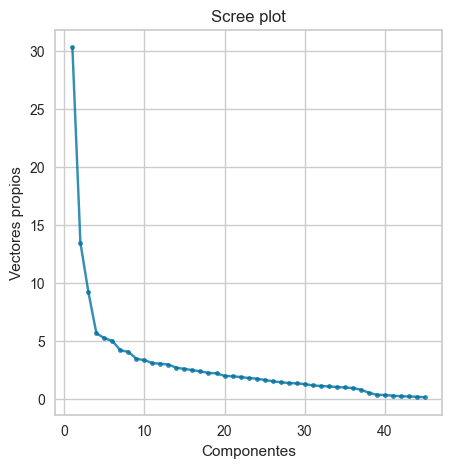

In [88]:
fig = plt.figure(figsize=(5,5));
plt.plot(range(1,len(myPCA.singular_values_ )+1),myPCA.singular_values_ ,alpha=0.8,marker='.');
#La nueva base son los vectores propios de la matriz de covarianza.
y_label = plt.ylabel('Vectores propios');
x_label = plt.xlabel('Componentes');
plt.title('Scree plot');

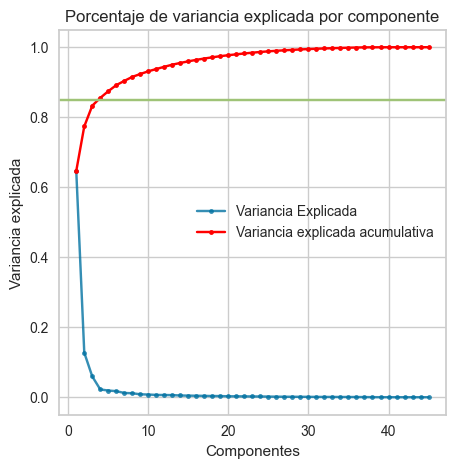

In [89]:
fig = plt.figure(figsize=(5,5));
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),myPCA.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),
         np.cumsum(myPCA.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');
plt.axhline(y=0.85, color='g', linestyle='-')

Vemos que como antes, podemos explicar el 85% de la varianza usando simplemente 3 componentes. Usando dos componentes, podemos llegar a explicar hasta casi un 80%.

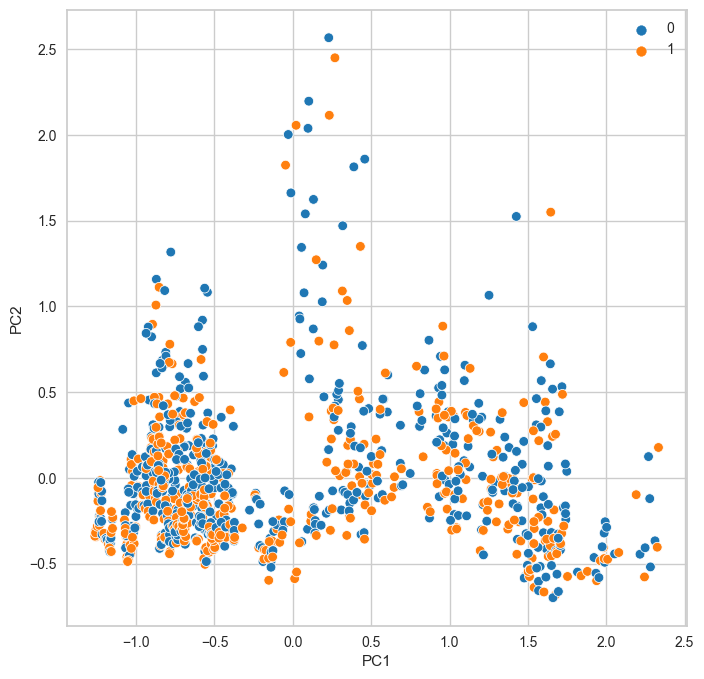

In [90]:
transformed_train = myPCA.transform(X_train_standarized_w[X_train_w.columns])
transformed_train


X_train_standarized_w[['PC1','PC2','PC3']] = transformed_train[:,:3]

fig = plt.figure(figsize=(8,8))
_ = sns.scatterplot(x='PC1', y='PC2', data=X_train_standarized_w, hue=y_train_w, palette='tab10')

Tal y como sucedia antes, tenemos que nuestro PCA no es capaz de generar una buena separabilidad de nuestras clases. Y como antes parece es que haya tres grupos, aunque con valores de las dos clases. Apenas hay diferencias entre ambos(si nos fijamos en los dos puntos de 0.0, -0.5 en el de arriba son de la clase 0 y aquí los clasifica como que son de la clase 1.

In [91]:
import plotly.express as px

fig = px.scatter_3d(X_train_standarized_w, x='PC1', y='PC2', z='PC3',color=y_train_w)
fig.show()

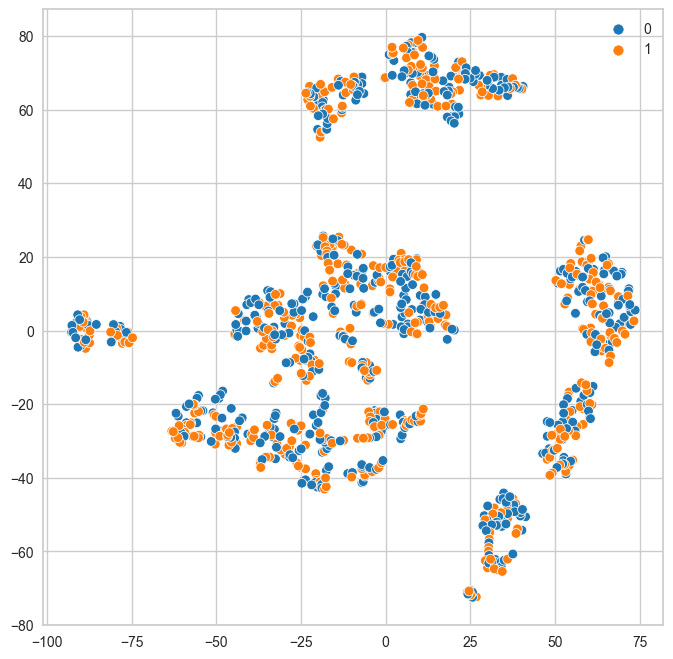

In [92]:
from sklearn.manifold import TSNE

transformed_train = TSNE(n_components=2, perplexity=10, n_iter=2000, init='pca').fit_transform(X_train_standarized_w[X_train_w.columns])

fig = plt.figure(figsize=(8,8))
sns.scatterplot(x=transformed_train[:,0], y=transformed_train[:,1], hue=y_train_w, palette='tab10');

Otra vez, apenas poder ver las diferencis entre ambos t-SNE.

#### Aplicamos una regresión logística

In [93]:
lr = LogisticRegression(max_iter=100000)
print(np.mean(cross_val_score(lr,X_train_w,y_train_w,cv=10)))

0.6268383838383838


Lo que podemos decir es que ahora vemos que el error de validación cruuzada ha mejorado. Esto significa que el modelo está funcionando mejor en este conjunto en comparación con la evaluación que hemos hecho anteriormente. Esto nos indica que a priori el modelo ha aprendido más sobre la relación entre las características y el target, o que el modelo se ha vuelto más generalizable a nuevos datos.

#### Exploración Bayesiana

In [94]:
param = {'penalty':['l2','l1'],
         'C':[10000, 1000, 100, 10, 1.0, 0.1, 0.01, 0.001],
         'solver': ['lbfgs', 'liblinear', 'saga'] #'newton-cg', 'newton-cholesky', 'sag', 
        }

lr = LogisticRegression(max_iter=100000,random_state=42, verbose=False)
lr_bs = BayesSearchCV(lr,param,n_iter=10, 
                        cv=TimeSeriesSplit(n_splits=10, gap=w+1), 
                        scoring=make_scorer(mean_squared_error, greater_is_better=False),
                        n_jobs=-1, 
                        refit=True, random_state=42)         
lr_bs.fit(X_train_w, y_train_w);

In [95]:
show_html(pd.DataFrame(lr_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

In [96]:
print(classification_report(lr_bs.predict(X_test_w), y_test_w, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.75      0.57      0.65       180
           1       0.35      0.55      0.43        76

    accuracy                           0.57       256
   macro avg       0.55      0.56      0.54       256
weighted avg       0.63      0.57      0.58       256



Vale, vemos que ahora ya no tenemos unas clases tan desbalanceadas, almenos ahora tenemos más de dos muestras en la clase support. Pero analizemos que está ocurriendo.

Ahora cabe recalcar que tenemos otra variable, la cuál es: **GOOGLE-V**. Ploteemosla:

In [97]:
nasdaq_data['GOOGLE-V'].loc[:1000].iplot(fill=False,colors=['blue'])

In [98]:
nasdaq_data['GOOGLE-V'].loc[1000:].iplot(fill=False,colors=['blue'])

Vale, tenemos una gran diferencia. Ahora tenemos que en el conjunto de test, la tendencia es parecida a la que tienen a lo largo de los días el conjunto de entrenamiento. Ahora este conjunto de test, parece adoptar una forma "neutral", con algunas subidas y bajadas, pero que parece que se mantiene *constante* en forma a lo largo de los días. Pero eso sí, con algunos picos, los cuáles estos ya se ven en el conjunto de entrenamiento.

Ahora ha sido capaz nuestro clasificador de aparentemente ver qué está pasando. Aunque si nos fijamos tenemos uan accuracy del modelo que parece que no ha mejorado con respecto al error de validación cruzada.

Esto nos está diciendo que el modelo se está sobreajustando ajustando con los datos de entrenamiento y no está generalizando bien a los datos de nuevos que se encuentran en el conjunto del test.

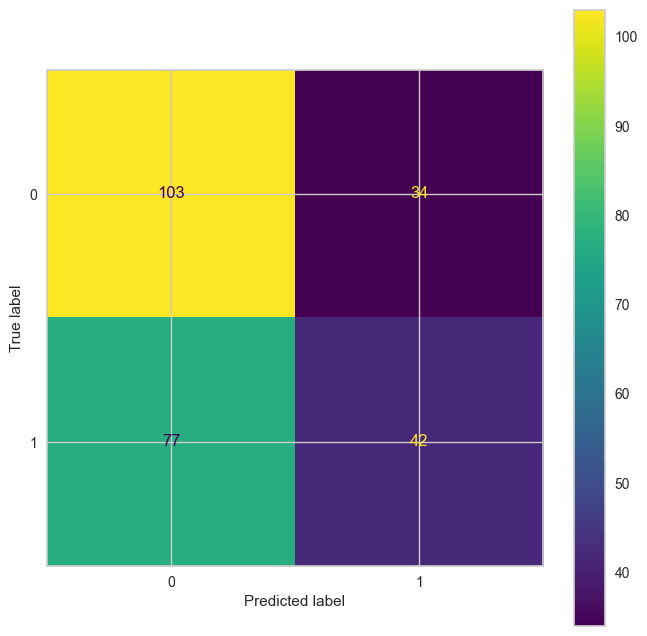

In [99]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_bs, X_test_w, y_test_w, display_labels=['0','1'], ax=plt.subplot());

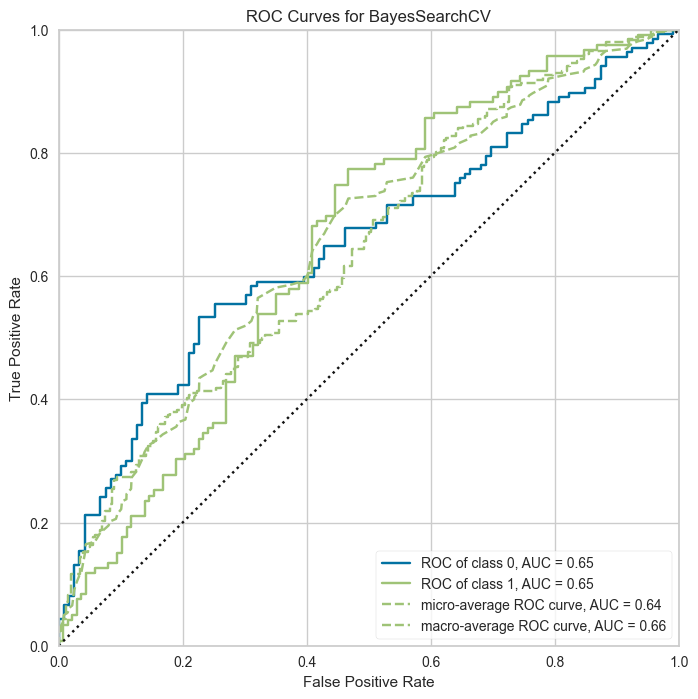

In [100]:
plt.figure(figsize=(8,8));
roc_auc(lr_bs, X_train_w, y_train_w, X_test_w, y_test_w, classes=['0','1']);

Ahora la curva ROC del clasificador de regresión logística tiene un mejor aspecto. Ambas areas bajo la curva (AUC) son de 0.65, lo que indicaría que el clasificador funciona relativamente bien.

In [101]:
c = choice(X_test_w.shape[0], size=200, replace=False)
pi = permutation_importance(lr_bs, X_test_w.to_numpy()[c], y_test_w[c], n_jobs=-1, random_state=42)
var_imp = pd.DataFrame({'importance': pi.importances_mean}, index=X_train_w.columns[:])

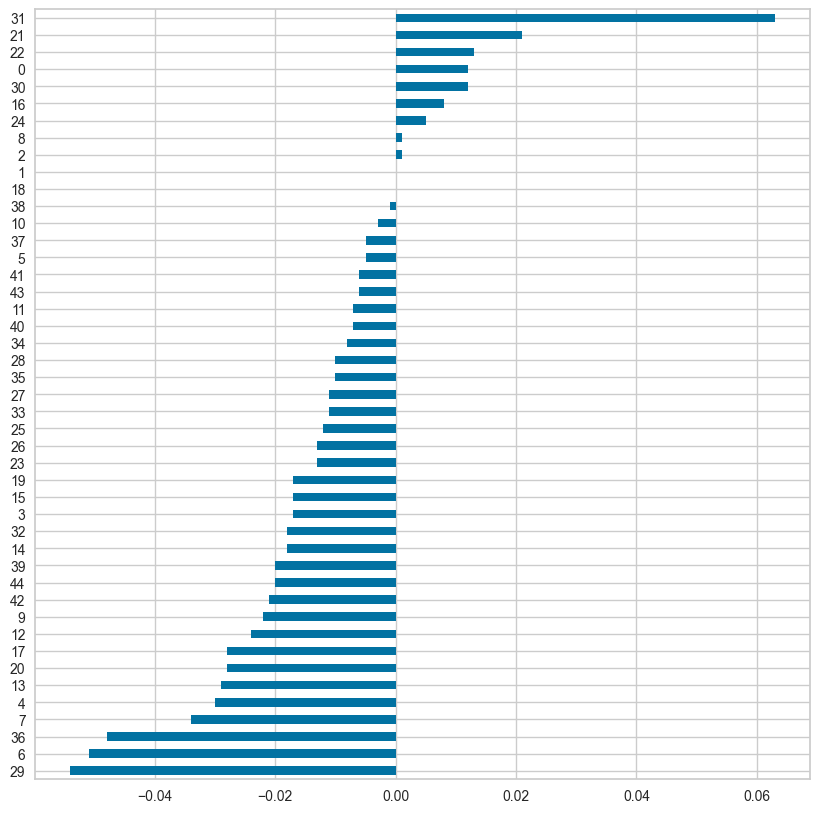

In [102]:
var_imp.sort_values(by='importance').plot.barh(figsize=(10,10), legend=False);

Si nos fijamos en la importancia, ahora tenemos que le ha dado una gran importancia al atributo que nos ha servido para poder generar la variable target para el volumen de las acciones de la tecnológica GOOGLE.

#### MLP 

In [103]:
mlp = MLPClassifier(max_iter=2500000,random_state=42, verbose=False, early_stopping=True)
print(np.mean(cross_val_score(mlp,X_train_w,y_train_w,cv=10)))

0.5536565656565656


In [104]:
param = {'hidden_layer_sizes':[10, 50, 100, 200, 300, 400, 500], 
         'activation':['logistic', 'relu', 'tanh', 'identity'], 
         'alpha':[0.00001, 0.0001, 0.001, 0.01],
         'momentum': [0.99, 0.95, 0.90, 0.85],
         'solver': ['adam', 'lbfgs', 'sgd'],
         'learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
         'n_iter_no_change':[10, 20, 30, 40, 50, 60, 80, 100, 200], 
         'learning_rate': ['constant', 'invscaling', 'adaptive']}

mlp =  MLPClassifier(max_iter=2500000,random_state=42, verbose=False, early_stopping=True)
mlp_bs = BayesSearchCV(mlp,param,n_iter=15, 
                        cv=TimeSeriesSplit(n_splits=10, gap=w+1),
                        n_jobs=-1, 
                        refit=True, random_state=42)    
mlp_bs.fit(X_train_w, y_train_w);

In [105]:
show_html(pd.DataFrame(mlp_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

In [106]:
mean_squared_error(y_test_w,mlp_bs.predict(X_test_w)), mean_absolute_error(y_test_w,mlp_bs.predict(X_test_w))

(0.43359375, 0.43359375)

In [107]:
print(classification_report(mlp_bs.predict(X_test_w), y_test_w,target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.74      0.57      0.65       178
           1       0.36      0.55      0.44        78

    accuracy                           0.57       256
   macro avg       0.55      0.56      0.54       256
weighted avg       0.63      0.57      0.58       256



Obtenemos un informe de clasificación, casi idéntico al realizado con el modelo de regresión lógistica. Solo vemos que 2 muestras que estaban en la clase del 0 han pasado a la clase alcista. Por lo tanto vemos qye ambos modelos se comportan de forma parecida.

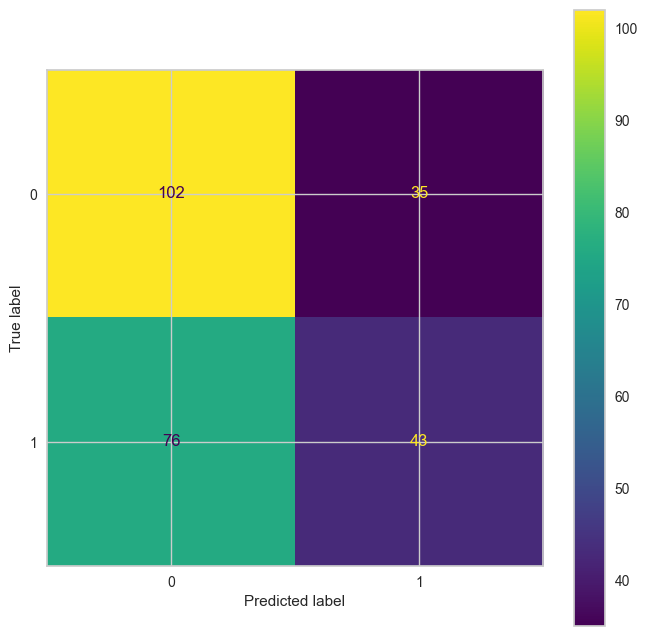

In [108]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(mlp_bs, X_test_w, y_test_w, display_labels=['0','1'], ax=plt.subplot());

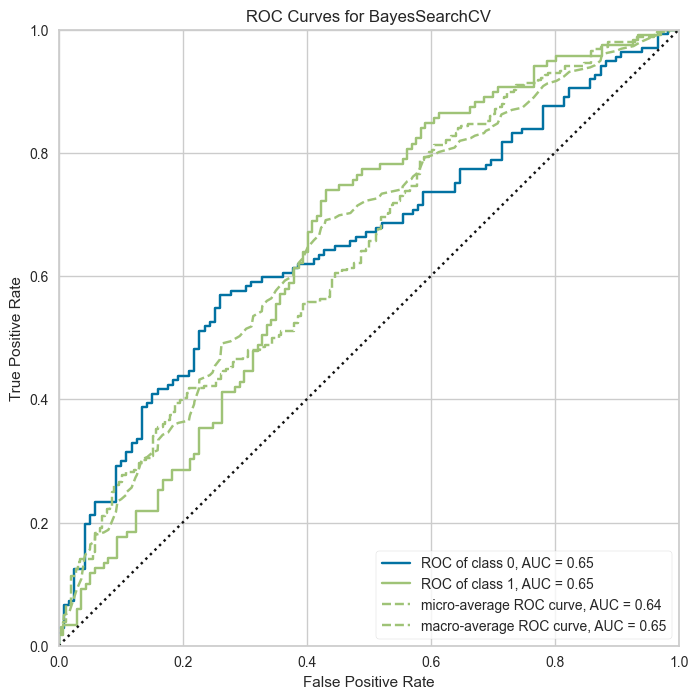

In [109]:
plt.figure(figsize=(8,8));
roc_auc(mlp_bs, X_train_w, y_train_w, X_test_w, y_test_w, classes=['0','1']);

De hecho vemos que para ambos modelos con esta nueva variable hemos obtenido resultados parecidos. Tanto para las curvas ROC, como para los anteriores tests realizados.

In [110]:
c = choice(X_test_w.shape[0], size=200, replace=False)
pi = permutation_importance(mlp_bs, X_test_w.to_numpy()[c], y_test_w[c], n_jobs=-1, random_state=42)
var_imp = pd.DataFrame({'importance': pi.importances_mean}, index=X_train_w.columns[:])

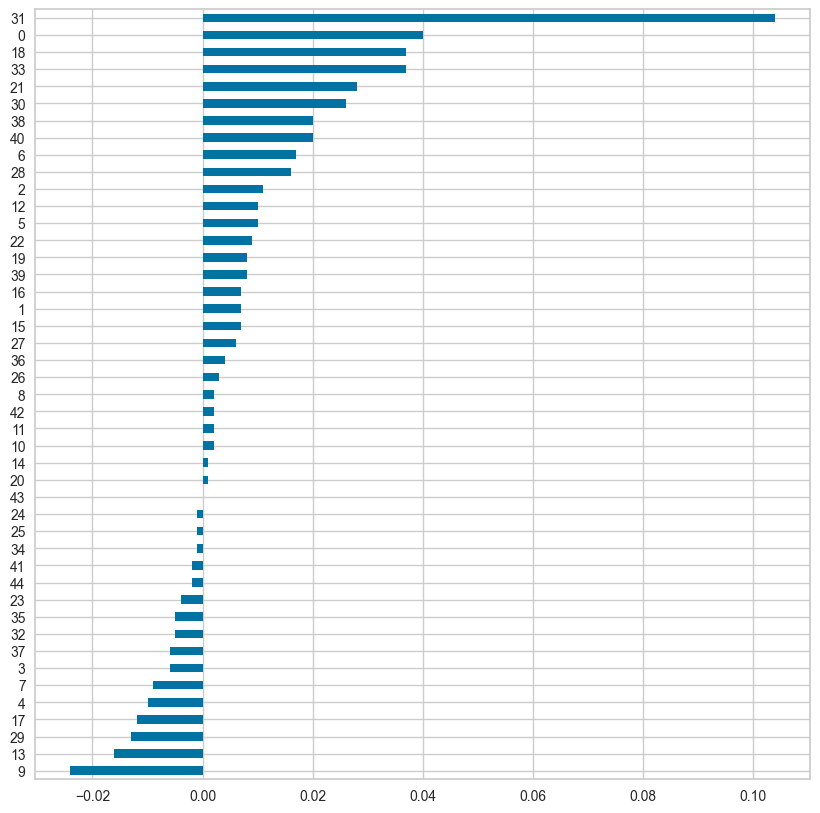

In [111]:
var_imp.sort_values(by='importance').plot.barh(figsize=(10,10), legend=False);

Si nos fijamos comparandolo con el otro modelo, tenemos que otra vez que el modelo MLP ha atribuido una importancia grande al atributo que nos ha servido para poder generar la variable target para el volumen de las acciones de la tecnológica GOOGLE.

Además, para tanto el modelo de **LR** como para el modelo de **MLP**, ambos han dado una importancia similiar a distintos atributos.

### Conclusiones

Como ya hemos vistos y comparado los resultados de los modelos para este nuevo problema usando la variable GOOGLE-V, solo falta acabar de resumir las distintas conclusiones que he ido mencionado a lo largo de los apartados.

Como hemos observado la gran diferencia entre las dos variables y la explicación para que en el primer problema se clasifique todo en la clase alcista(para el modelo LR) y casi todo(dos ejemplos bajista, para el modelo MLP) es debido a la naturaleza del precio de las acciones de GOOGLE-P que se encuentran en el conjunto de test. Y que en el conjunto de test, la tendencia del precio no tiene un carácter alcista y por lo tanto no es capaz de usar la información de ningun atributo para poder clasificar los ejemplos, ya que en el conjunto de entrenamiento como se observa los precios van creciendo. 
Los modelos de esta variable, se comportaban peor que un clasificador random cuándo nos hemos fijado en sus curvas ROC. Además el modelo LR no atribuia ninguna importancia al los atributos. A diferencia del modelo MLP que se atrevia a dar alguuna importancia a ciertos atributos y a ciertos dejándolos sin niguna importancia.

A diferencia de la variable del precio de Google, la variable del volumen de negociaciones tiene una naturaleza distinta. Ahora nuestros modelos, ambos(LR i MLP) ya son capaces de poder clasificar y distingir más ejemplos(de hecho más, en cantidad a la clase bajista). 

Esto es así, ya que ahora la tendencia del conjunto de test, es del mismo carácter que la del conjunto de entrenamiento. Aún así, queda visto que par datos que no ha visto, i.e los del conjunto test, los modelos sobreajustan los datos y pasan a tener uuna peor accuracy comparada con el error de validación cruzada realizada. Ambos modelos para esta varaible son casi iguales. 

Como vemos, si generalizamos, lo que va a suceder es que aunque parecia que ciertas variables tienen una cierta correlación esta no es real. Ya que usando solo los 1000 primeros días del conjunto de entrenamiento y los demás para el conjunto de test no es una buena idea. Podría suceder como es el caso de google, que el precio de las acciones no dejan de subir, pero luego en el conjunto de entrenamiento se estabilizan y ya el carácter no se puede predecir o no se puuede detectar que ahora el precio de las acciones puede llegar a ser bajista o incluso si tuviéramos otra clase, neutral. El mercado es demasiado variable y dinámico, y si probamos de hacerlo para todas las variables vamos a tener un comportamiento parecido. 

Así que, es posible clasificar las cotizaciones bursátiles como alcistas o bajistas, pero en general es muy difícil predecir con exactitud la dirección de los movimientos de las cotizaciones con un alto grado de certeza. Hay muchos factores que pueden influir en los precios de las acciones, como las condiciones económicas, las tendencias del mercado, los resultados de las empresas y los acontecimientos mundiales, etc. En consecuencia, los precios de las acciones pueden ser muy impredecibles y fluctuar significativamente de un día para otro como es el caso de la variable de GOOGLE-P, que en los últimos meses dejan de tener tendencia alcista(conjunto de test) y es imposible que nuestro modelo clasifique bien para estos días siguientes.

Así que en general, es más difícil predecir con exactitud los movimientos de las cotizaciones bursátiles que los del volumen de las acciones por las razones comentadas con anterioridad. Como resultado, los precios de las acciones pueden ser muy impredecibles y fluctuar significativamente de un día para otro.

Por otra parte, el volumen de acciones, que se refiere al número de acciones de una acción concreta que se negocian en un periodo de tiempo determinado, en nuestro problema un día, suelen ser menos volátiles y pueden ser más predecibles que los precios de las acciones. Sin embargo, sigue siendo difícil predecir con exactitud la dirección de los movimientos del volumen de las acciones con certeza,como hemos vistos nuestros modelos tienen una acuracy del 57%, solo un poco más comparado con un clasificador random. Pero en general, hay muchos factores que pueden influir en el volumen de las acciones, y puede verse afectado por los mismos tipos de acontecimientos y condiciones que afectan a los precios de las acciones.